# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
pd.set_option('display.max_colwidth', None)

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The primary objective of this project is to identify the key factors that influence the price of used cars. By analyzing a dataset of 426,000 vehicle listings, we aim to uncover trends and patterns that help explain why some cars are priced higher than others. These insights will support a used car dealership in optimizing its inventory selection and pricing strategies based on what consumers value most in a used vehicle. This analysis is guided by the CRISP-DM framework, a structured approach commonly used in the industry to solve data-driven business problems.


In [14]:
# Decribing the data that has been provided using Pandas functions

data=pd.read_csv('data/vehicles.csv')

# Shape and preview
print('Vehicles DataFrame Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()

Vehicles DataFrame Shape : (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [20]:
# Use Dataframe describe/view some basic statistical details 
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [22]:
# Exploring the data and describing the dataframe to get a list of provided attributes/features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [24]:
# Print % of Columns that are null in relation to the total number of columns
for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(data[column].isnull().sum() /
                                               data[column].shape[0]))

year : 0.28%
manufacturer : 4.13%
model : 1.24%
condition : 40.79%
cylinders : 41.62%
fuel : 0.71%
odometer : 1.03%
title_status : 1.93%
transmission : 0.60%
VIN : 37.73%
drive : 30.59%
size : 71.77%
type : 21.75%
paint_color : 30.50%


In [27]:
#Check the number of Null Columns
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [37]:
# Review the correlation of the dataset with the missing values
data.corr(numeric_only=True)

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


In [39]:
# - 'id' has no meaningful correlation with any other variables. It is a unique identifier and can be dropped.
# - 'price' has extremely weak correlation with both 'year' (-0.0049) and 'odometer' (0.0100),
#   suggesting that no strong linear relationship exists between price and these features alone.
# - 'year' and 'odometer' have a mild negative correlation (-0.1572),

In [43]:
# Eliminating id column out of the dataset to see if it makes a difference
data1 = data.drop('id', axis=1)
data1.corr(numeric_only=True)

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


In [77]:
# Updated Correlation Matrix Findings (after dropping 'id' column):
# 'price' has extremely weak correlation with both 'year' (-0.0049) and 'odometer' (0.0100),
# indicating that neither feature alone explains much about price in a linear way.
# 'year' and 'odometer' show a mild negative correlation (-0.1572),
# which makes intuitive sense — older cars generally have more mileage.

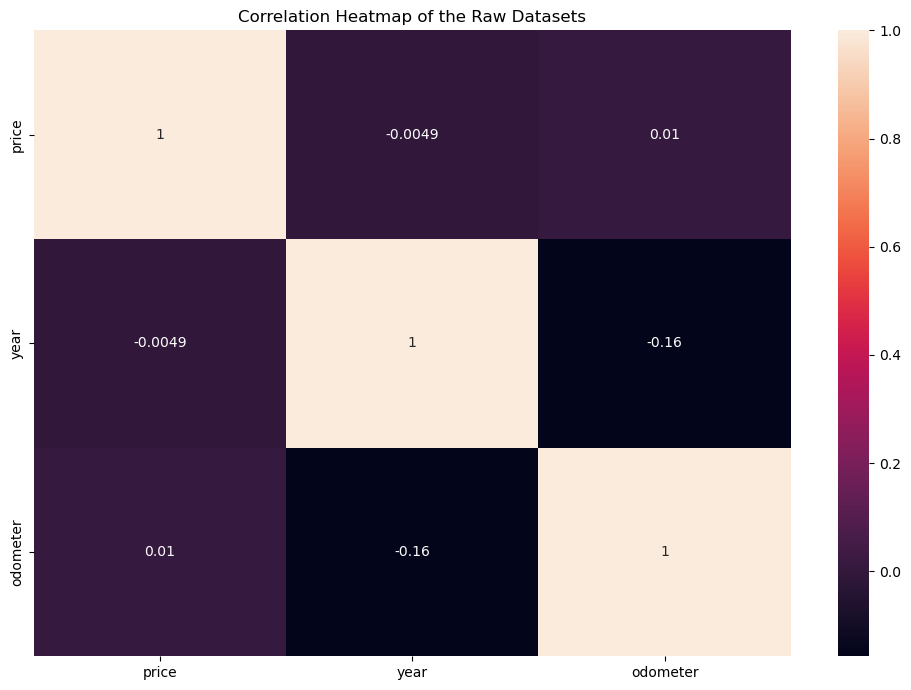

In [51]:
# Visualization of the provided datasets

fig, ax = plt.subplots(figsize=(10,7))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(data1.corr(numeric_only=True), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the Raw Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

In [ ]:
# The correlation matrix reveals weak linear relationships between variables.
# Surprisingly, there is no strong correlation between 'year', 'odometer', and 'price'.
# For instance, we would typically expect newer cars with lower mileage to have higher prices,

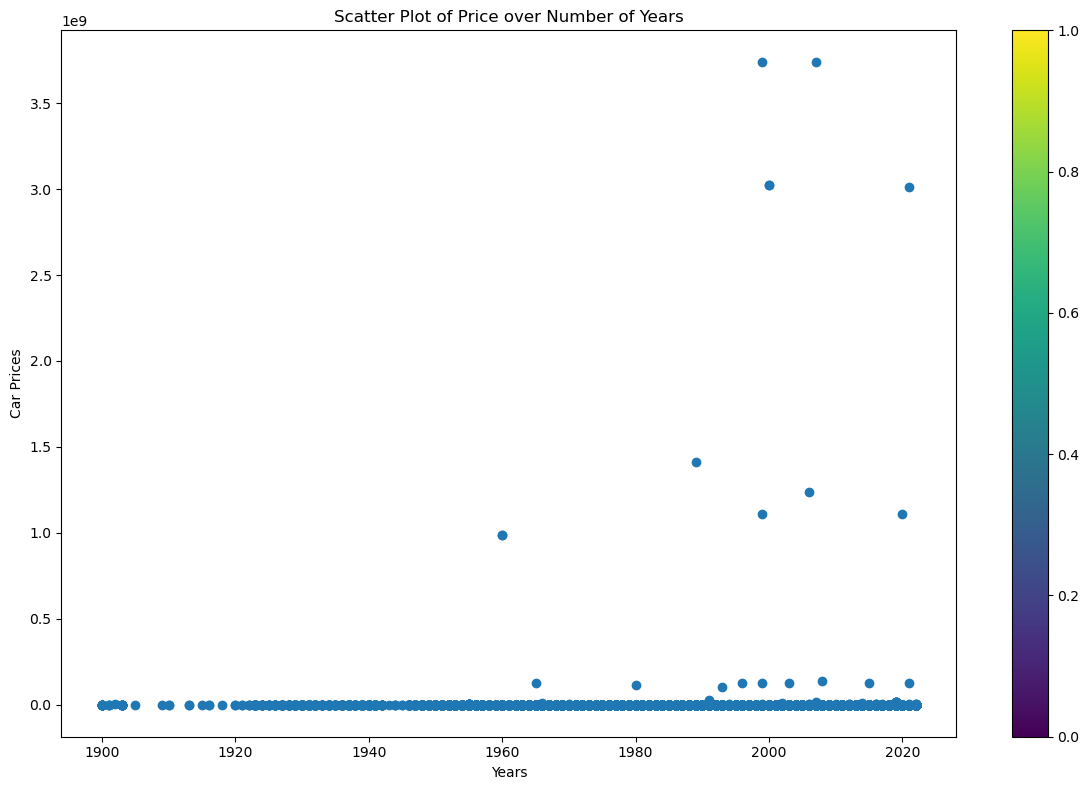

In [53]:
# Scatter plot of year of manufacture vs car price
plt.figure(figsize=(12,8))
plt.scatter(data['year'], data['price'])
 
# Adding Title to the Plot
plt.title("Scatter Plot of Price over Number of Years")
 
# Setting the X and Y labels
plt.xlabel('Years')
plt.ylabel('Car Prices')
plt.colorbar()
 
plt.show()

In [55]:
# Missing and NaN values in the dataset are distorting the visualizations, making some plots unclear or misleading.
# For example, a flat line at 0.0 appears due to missing car price values (NaNs), which obscures any real trend over time.

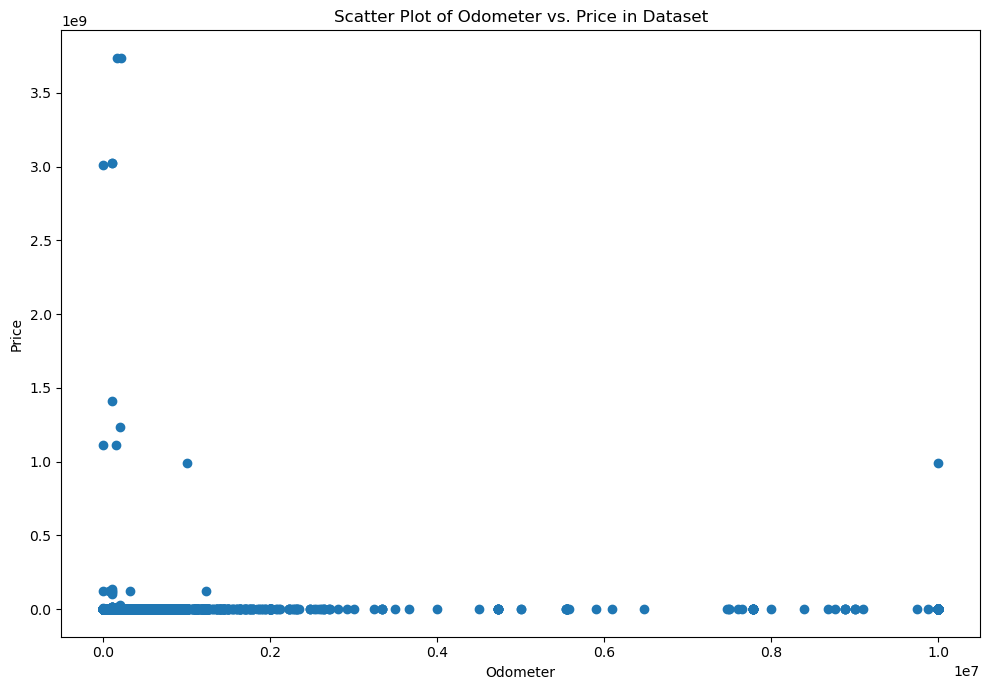

In [57]:
# Scatter plot of price vs odomoter to see if there is a Trend, i.e., the lower the odometer, the more 
# expensive or higher the car price

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(data['odometer'], data['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

In [59]:
# The visualizations are also being skewed by entries with a price of $0 and an odometer reading of 0.
# Since these are used cars, the odometer should always have a recorded value.
# A price of $0 might indicate that the vehicle has not yet been evaluated or priced in the dataset.
# However, both zero values for price and odometer likely represent missing or erroneous data
# and should be treated accordingly during data cleaning.

In [61]:
#df1 = data[(data['price']>0) & (data['odometer']>0)]
df1 = data.query("price > 0").dropna()
df1

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


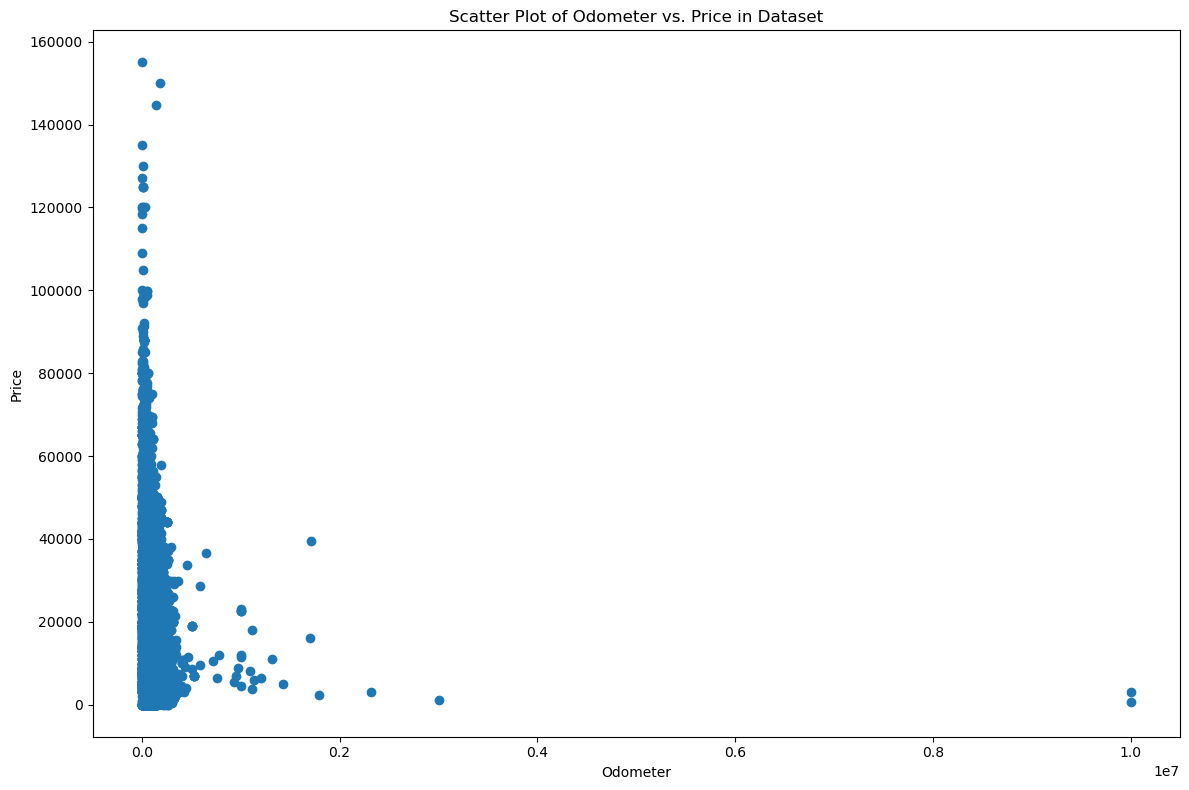

In [63]:
# Scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df1['odometer'], df1['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

In [ ]:
# Dropping rows with null values reduced the dataset to approximately 32,000 records.
# However, the data remains skewed toward unusually low values.
# Below is a summary of the minimum and maximum values for 'odometer' and 'price'
# based on the current filtered dataset.

In [65]:
print("Minimum Price of cars in filtered dataset: ", df1['price'].min())
print("Maximum Price of cars in filtered dataset: ", df1['price'].max())
print("Minimum Odometer on cars in filtered dataset: ", df1['odometer'].min())
print("Maximum Odometer on cars in filtered dataset: ", df1['odometer'].max())

Minimum Price of cars in filtered dataset:  1
Maximum Price of cars in filtered dataset:  155000
Minimum Odometer on cars in filtered dataset:  0.0
Maximum Odometer on cars in filtered dataset:  9999999.0


In [ ]:
# In the data preparation section, we will handle low and zero values by applying techniques such as
# median and mean imputation, along with other standardization methods to ensure data consistency.

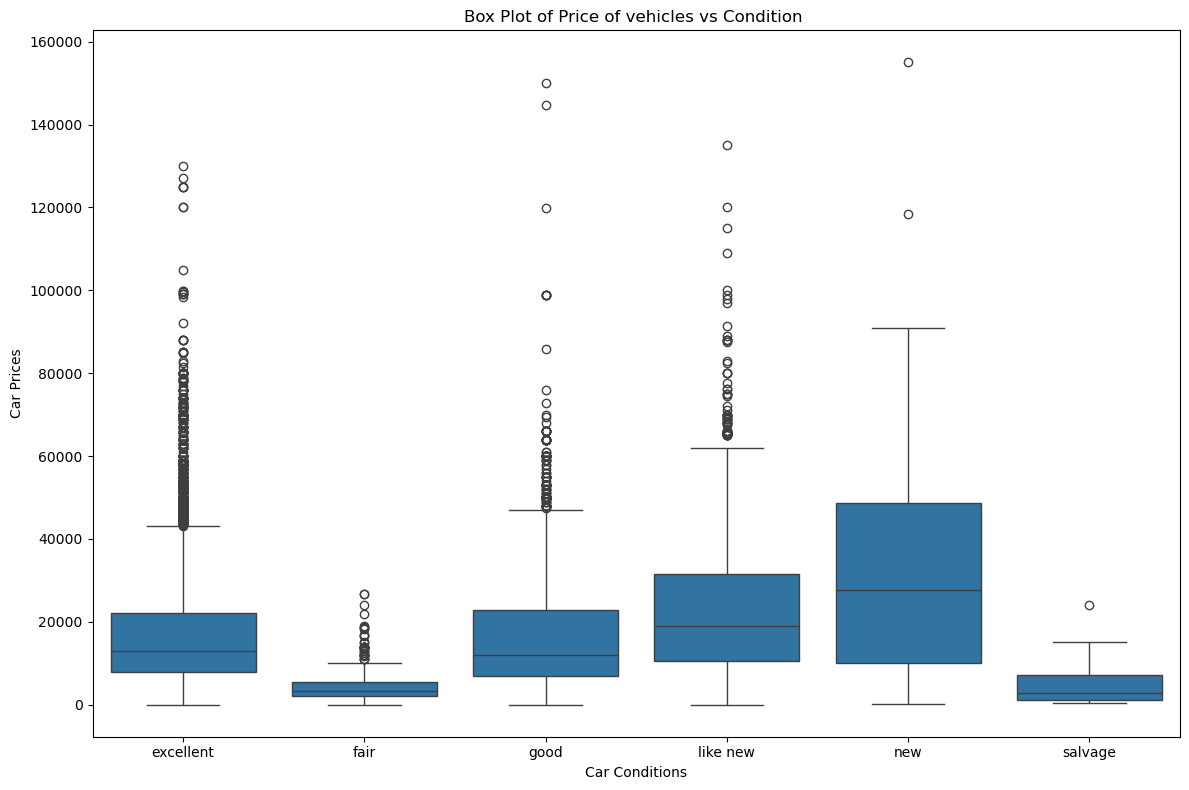

In [67]:
#plt.figure(figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))

#create seaborn boxplot
ax = sns.boxplot(x=df1["condition"], y=df1["price"], ax=ax)

# Adding Title to the Plot
ax.set_title("Box Plot of Price of vehicles vs Condition ")
 
# Setting the X and Y labels
ax.set_xlabel("Car Conditions")
ax.set_ylabel("Car Prices")

plt.show()

In [69]:
# As expected, cars listed as "new", "excellent", "like new", and "good" have the highest average prices,
# while "salvage" and "fair" conditions correspond to the lowest prices.
# Interestingly, all condition categories include vehicles with a $0 price, which likely indicates missing or invalid data.


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [81]:
# Copying the loaded dataset and dropping null rows
data_copy = data.copy().dropna()
data_copy.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [83]:
# print the number of records
data_copy.shape

(34868, 18)

In [85]:
# Upon reviewing the records, it is clear that 'id' and 'VIN' do not contribute to predicting car price,
# as they serve only as unique identifiers. Additionally, 'region' and 'state' are closely related,
# with 'region' often representing very localized areas. Since some regions have only one listing,
# we will remove the 'region' column to reduce redundancy and potential noise in the data.

In [87]:
# Drop the following columns
data_copy.drop('id', axis=1, inplace=True)
data_copy.drop('VIN', axis=1, inplace=True)
data_copy.drop('region', axis=1, inplace=True)
data_copy

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
126,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white,al
127,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white,al
128,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white,al
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy
426833,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy


In [89]:
#Check for null columns
data_copy.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [91]:
# There are no null values, but need to check on columns with zero values.
# we can see that there are some records with zero values
s = data_copy.eq(0).any()
s

price            True
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

In [93]:
# Only Price and Odometer are the values with zero values

In [95]:
# Get the count of Zeros in column 'price' 
count = (data_copy['price'] == 0).sum()
print('Count of zeros in Column  price : ', count)

Count of zeros in Column  price :  2372


In [97]:
# Get the count of Zeros in column 'odometer' 
count = (data_copy['odometer'] == 0).sum()
print('Count of zeros in Column  odometer : ', count)

Count of zeros in Column  odometer :  81


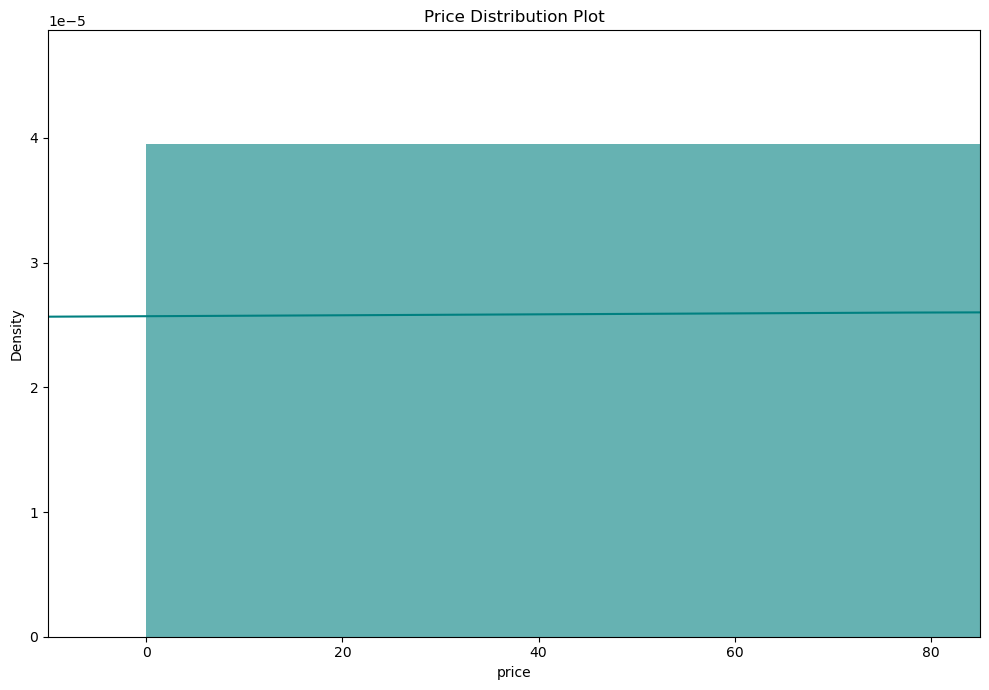

In [99]:
# Let's look at the data in Price Column and see the distribution of the values
fig, ax = plt.subplots(figsize=(10,7))
ax = data_copy["price"].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
data_copy["price"].plot(kind='density', color='teal')
ax.set_title('Price Distribution Plot')
ax.set(xlabel='price')
plt.xlim(-10,85)
plt.show()

In [101]:
# mean Price
print('The mean of "Price" is %.2f' %(data_copy["price"].mean(skipna=True)))
# median Price
print('The median of "Price" is %.2f' %(data_copy["price"].median(skipna=True)))

The mean of "Price" is 15837.45
The median of "Price" is 12000.00


In [105]:
# mean Odometer
print('The mean of "Odometer" is %.2f' %(data_copy["odometer"].mean(skipna=True)))
# median Odometer
print('The median of "Odometer" is %.2f' %(data_copy["odometer"].median(skipna=True)))

The mean of "Odometer" is 107399.09
The median of "Odometer" is 104000.00


In [107]:
# With 34,868 records, we have 81 records with zero odometers and 2,372 with zero dollars for price.
# We will remove these records 

In [109]:
# Removing records with zero for Odometer and Prices
# Remove rows with all 0s in a Dataframe
data_copy.drop(data_copy[data_copy['price'] == 0].index, inplace = True)
data_copy.drop(data_copy[data_copy['odometer'] == 0].index, inplace = True)
data_copy

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
268,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white,al
337,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,fwd,full-size,truck,white,al
338,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,4wd,full-size,truck,black,wy
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy


In [111]:
# Quick check to ensure all rows do not include any zero values
s = data_copy.eq(0).any()
s

price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer        False
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

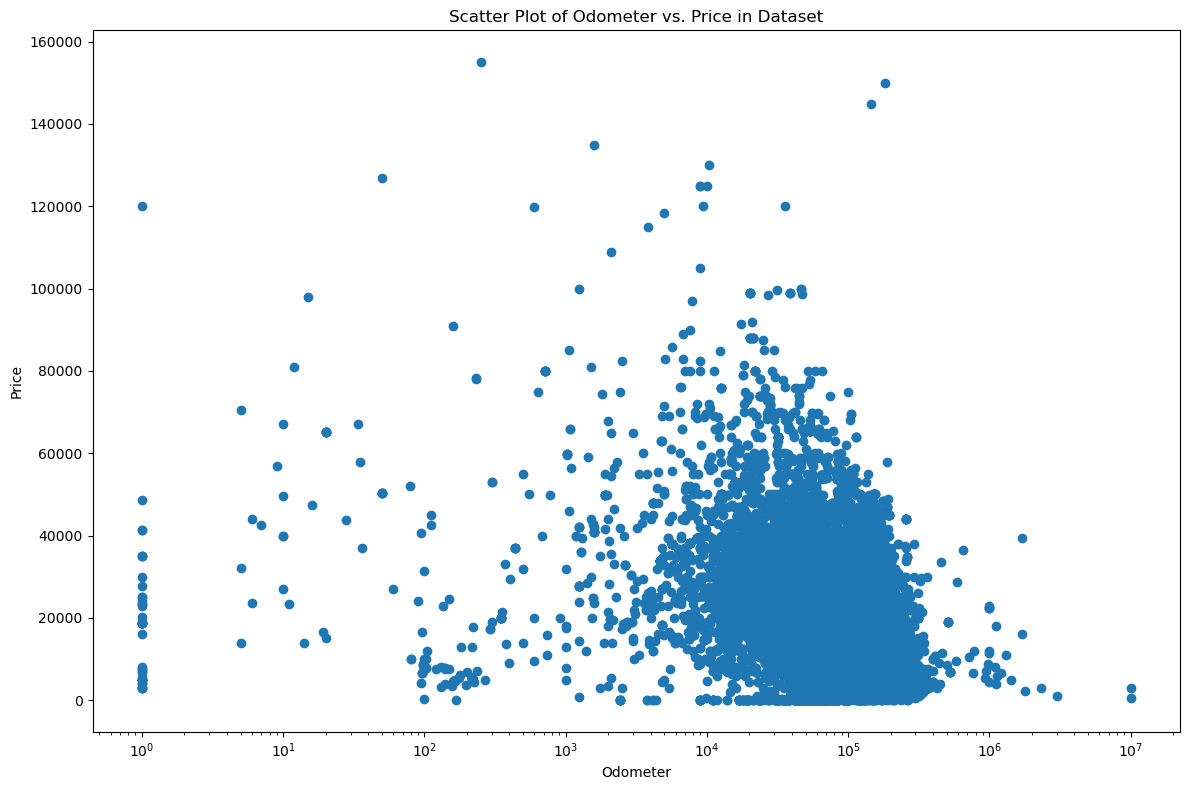

In [113]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
plt.xscale("log") 
ax.scatter(data_copy['odometer'], data_copy['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

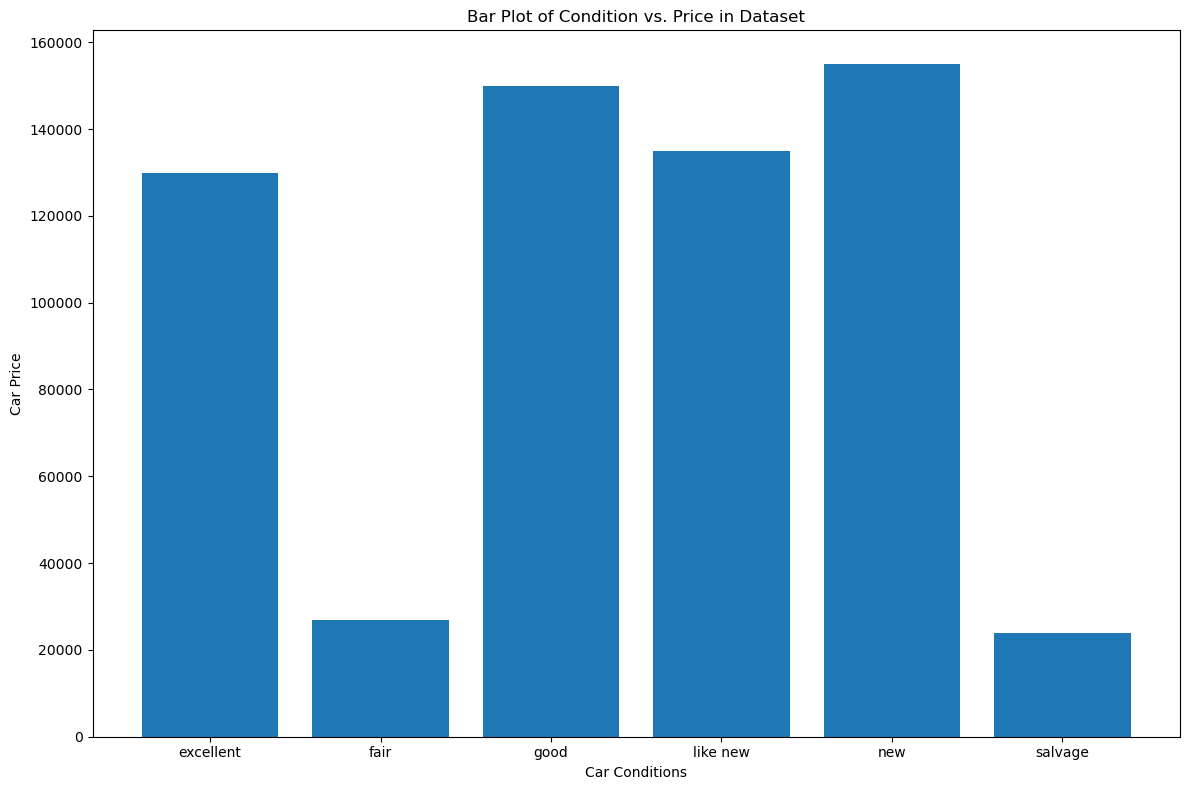

In [115]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(data_copy["condition"],data_copy["price"])
# set a title and labels
ax.set_title('Bar Plot of Condition vs. Price in Dataset')
ax.set_xlabel('Car Conditions')
ax.set_ylabel('Car Price')
plt.show()

#plt.bar(data_copy["condition"],data_copy["price"])
#plt.show()

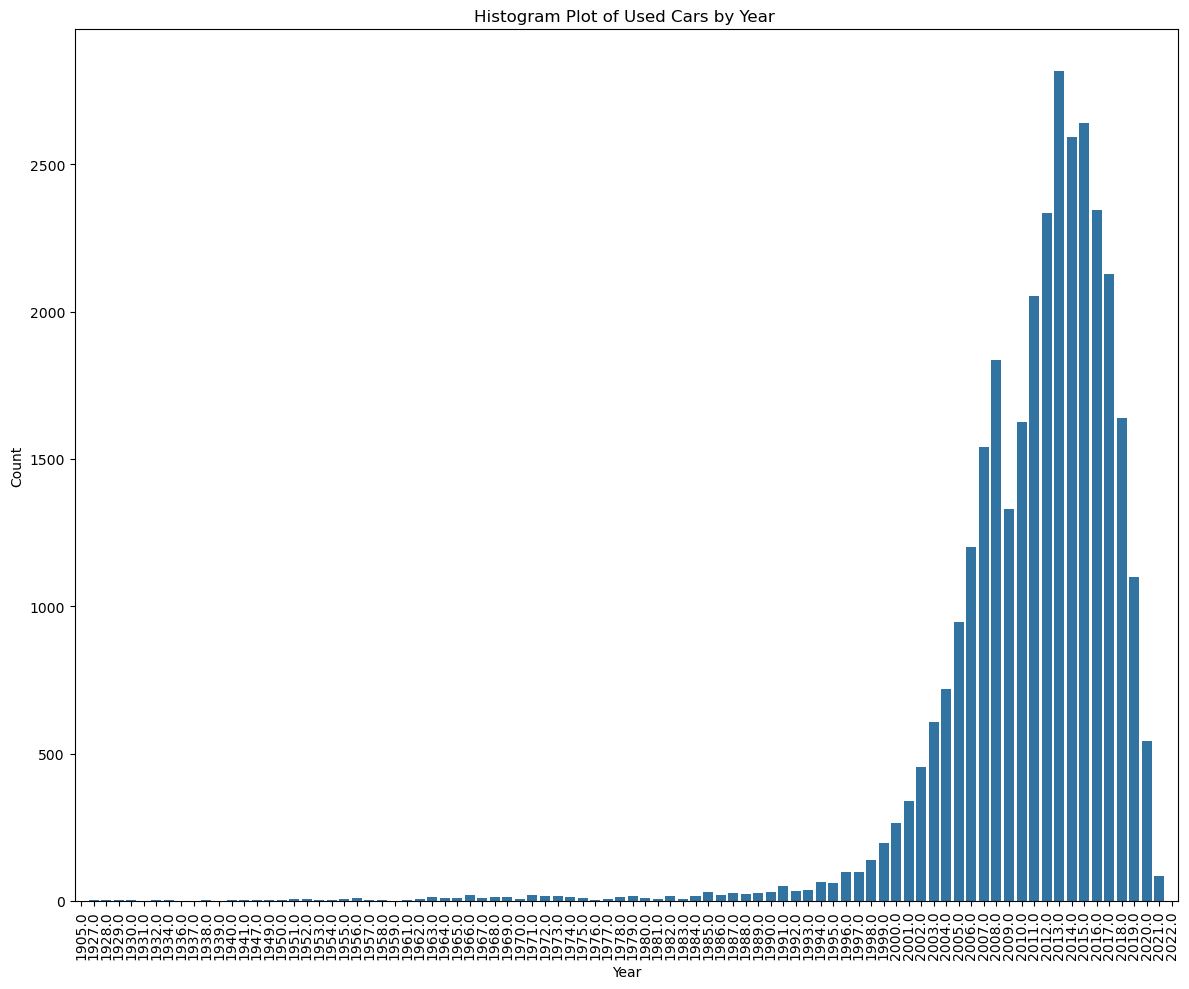

In [117]:
# Plot the number of used car counts by year

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='year', data=data_copy , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Year ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.show()

In [119]:
# From the chart above, you can see that the records from 1905 to 1990 were not extensive. You restrict the records in
# the model from 1991

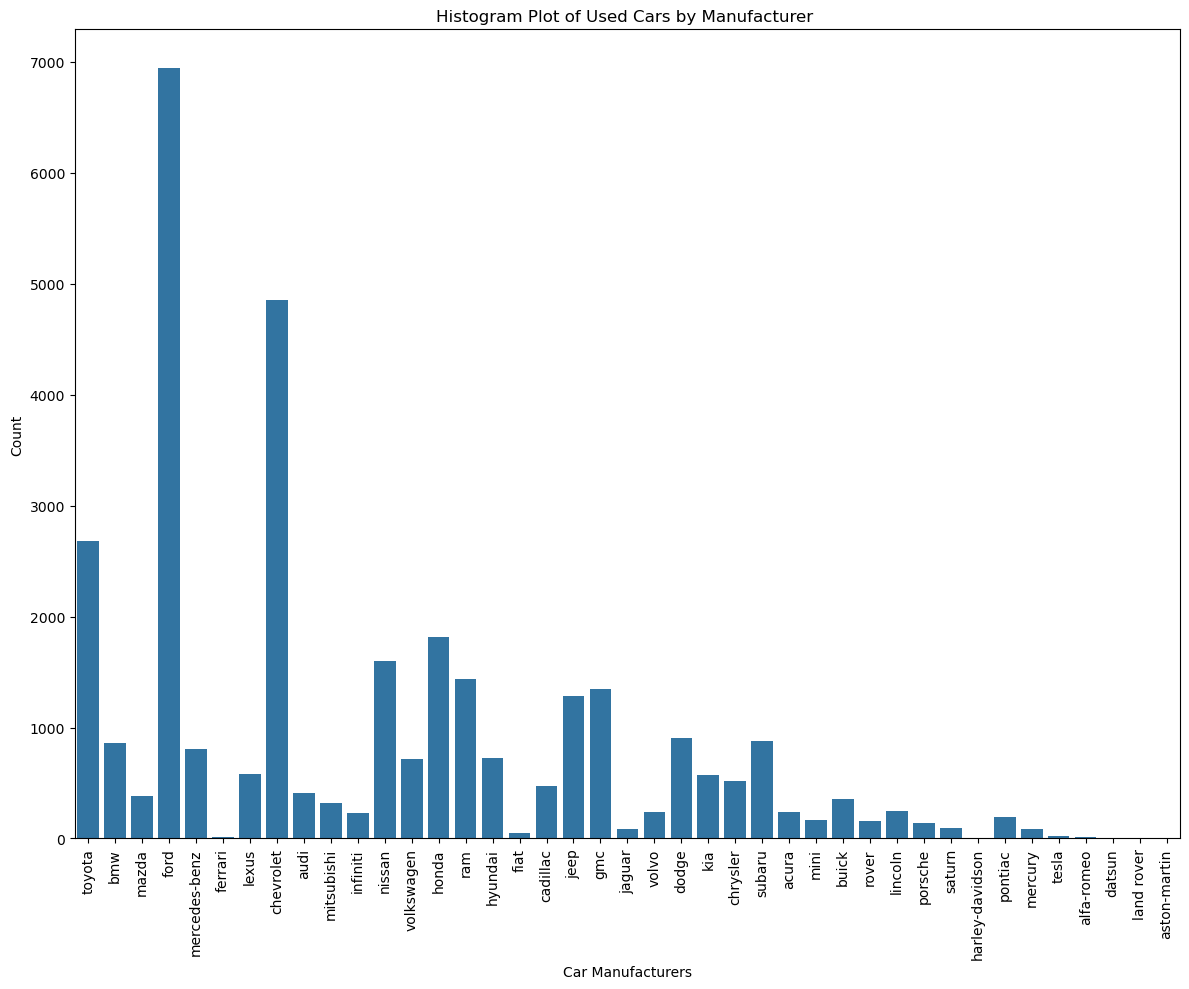

In [121]:
# Plot the number of used car counts by manufacturer

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='manufacturer', data=data_copy , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Manufacturer ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Car Manufacturers")
ax.set_ylabel("Count")

plt.show()

In [123]:
# From the chart above, you can see that Ford, Chevrolet and Toyota are the top 3 manufacturers

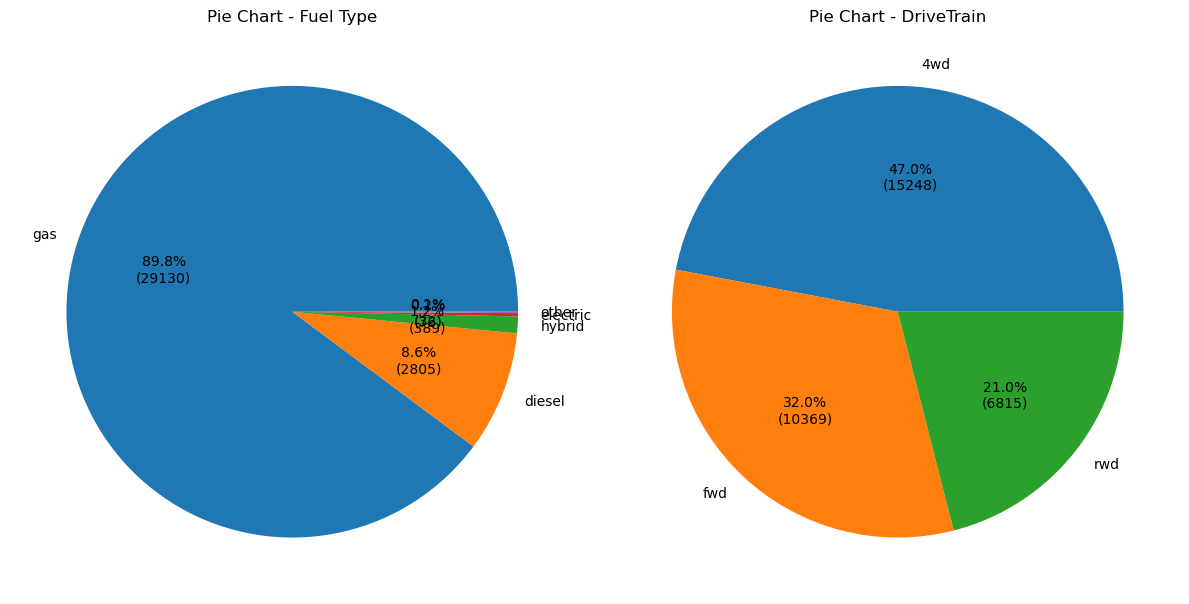

In [125]:
# Plot some pie charts to visualize the number of used cars based on car features
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

#plt.pie(df['LoanStatus'].value_counts().values, labels=df['LoanStatus'].value_counts().index, autopct=fmt)

# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Fuel Type')
s = data_copy['fuel'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - DriveTrain')
s = data_copy['drive'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))

plt.show()

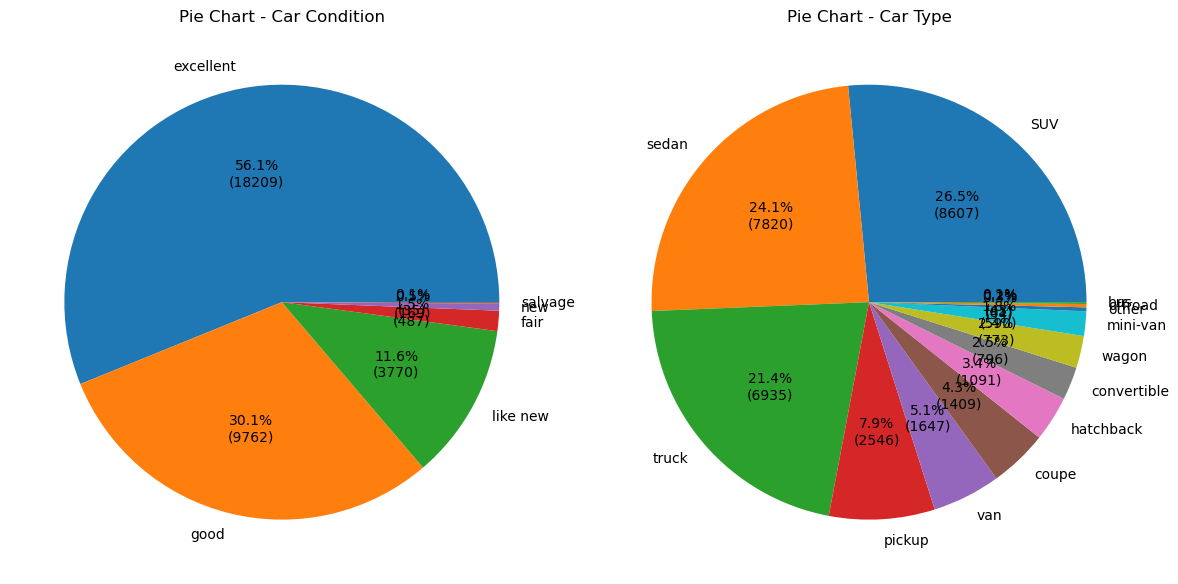

In [127]:
# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Car Condition')
s = data_copy['condition'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - Car Type')
s = data_copy['type'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

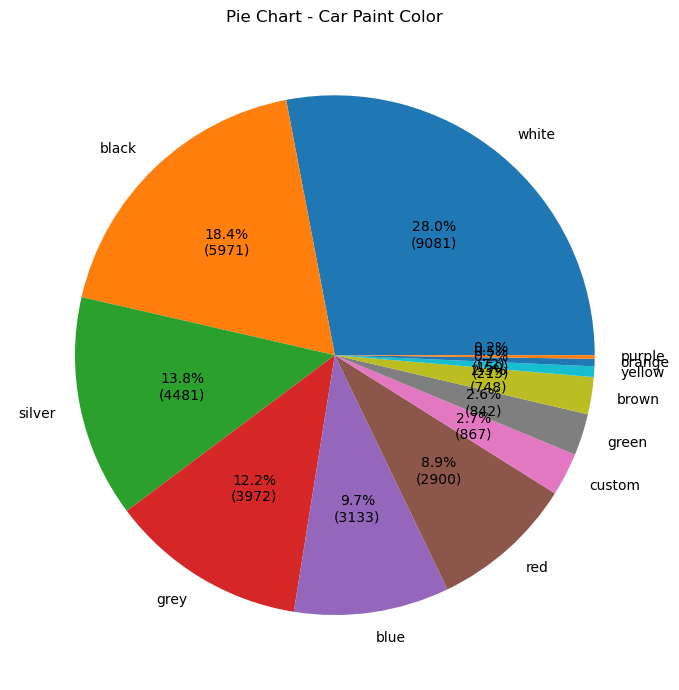

In [129]:
# create a figure with subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,7))

# plot each pie chart in a separate subplot

ax.set_title('Pie Chart - Car Paint Color')
s = data_copy['paint_color'].value_counts()
ax.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

In [133]:
#Lets look at the Correlation after some data manipulation
data_copy.corr(numeric_only=True)

,price,year,odometer
price,1.000000,0.317258,-0.233163
year,0.317258,1.000000,-0.212234
odometer,-0.233163,-0.212234,1.000000


In [135]:
#The correlation between price, odometer and year is not strong. Only year has a positive value

In [137]:
#Lets review the uniqueness of the following features state, paint_color, manufacturer, model, cylinders,
#type, transmission and title_status
data_copy['state'].value_counts()

state
fl    3395
ca    3296
ny    1722
tx    1295
mi    1222
wi    1111
nc    1091
oh    1033
ia    1030
pa     999
or     984
va     978
tn     863
mn     792
nj     789
co     759
vt     676
ma     655
il     634
id     604
az     599
ks     599
in     565
ky     543
ok     500
sc     449
al     419
ak     403
mo     381
mt     348
wa     312
ct     298
ga     270
nm     238
ri     230
nv     221
hi     207
me     197
nh     192
dc     182
md     161
ut     153
sd     149
ar     145
ne     134
nd     133
la     130
de     109
wv      88
wy      87
ms      62
Name: count, dtype: int64

In [139]:
data_copy['paint_color'].value_counts()

paint_color
white     9081
black     5971
silver    4481
grey      3972
blue      3133
red       2900
custom     867
green      842
brown      748
yellow     215
orange     150
purple      72
Name: count, dtype: int64

In [141]:
data_copy['manufacturer'].value_counts()

manufacturer
ford               6945
chevrolet          4851
toyota             2682
honda              1818
nissan             1602
ram                1439
gmc                1350
jeep               1280
dodge               903
subaru              875
bmw                 863
mercedes-benz       804
hyundai             725
volkswagen          717
lexus               581
kia                 571
chrysler            514
cadillac            469
audi                408
mazda               381
buick               359
mitsubishi          323
lincoln             246
acura               240
volvo               237
infiniti            226
pontiac             198
mini                167
rover               158
porsche             135
saturn               97
jaguar               82
mercury              81
fiat                 47
tesla                19
alfa-romeo           15
ferrari               9
harley-davidson       7
datsun                3
aston-martin          3
land rover            2
Nam

In [143]:
data_copy['model'].value_counts()

model
f-150                     812
silverado 1500            771
1500                      408
2500                      267
silverado 2500hd          255
                         ... 
rondo ex                    1
sentra special edition      1
2500 st                     1
g37 x awd                   1
cruze, 2lt                  1
Name: count, Length: 4943, dtype: int64

In [145]:
data_copy['cylinders'].value_counts()

cylinders
6 cylinders     10773
4 cylinders     10655
8 cylinders     10017
10 cylinders      548
5 cylinders       270
other              92
3 cylinders        66
12 cylinders       11
Name: count, dtype: int64

In [147]:
data_copy['type'].value_counts()

type
SUV            8607
sedan          7820
truck          6935
pickup         2546
van            1647
coupe          1409
hatchback      1091
convertible     796
wagon           773
mini-van        590
other            94
offroad          81
bus              43
Name: count, dtype: int64

In [149]:
data_copy['transmission'].value_counts()

transmission
automatic    30093
manual        1645
other          694
Name: count, dtype: int64

In [151]:

data_copy['title_status'].value_counts()

title_status
clean         31258
rebuilt         786
salvage         239
lien            134
missing          14
parts only        1
Name: count, dtype: int64

In [153]:
# Based on the data for these features, we can drop these features due to the following:

# state has a lot of options and this feature should not have a big impact on price
# paint_color has a number of unique values with white being the most dominant. Should not have a big impact on price
# manufacturer is varied with ford with the most number of vehicles
# model has 4943 and should not have a big impact on price
# cylinders should not have a big impact on price
# type should not have a big impact on price
# transmission is mainly automatic so we can drop
# title_status can be dropped, we have condition field

In [155]:
# Remove these features above from the datasets state, paint_color, manufacturer, model, cylinders,
# type, transmission and title_status

data_copy.drop(['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
data_copy.head(5)

,price,year,condition,fuel,odometer,drive,size
215,4000,2002.0,excellent,gas,155000.0,fwd,compact
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size
268,9000,2008.0,excellent,gas,56700.0,rwd,compact
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size
338,4000,1972.0,fair,gas,88100.0,rwd,full-size


In [157]:
# Let's reviwed the unique values for the features that we are planning to keep for the model

In [159]:
data_copy['condition'].value_counts()

condition
excellent    18209
good          9762
like new      3770
fair           487
new            169
salvage         35
Name: count, dtype: int64

In [161]:
data_copy['fuel'].value_counts()

fuel
gas         29130
diesel       2805
hybrid        389
electric       76
other          32
Name: count, dtype: int64

In [163]:
data_copy['size'].value_counts()

size
full-size      19118
mid-size        8920
compact         3809
sub-compact      585
Name: count, dtype: int64

In [165]:
data_copy['drive'].value_counts()

drive
4wd    15248
fwd    10369
rwd     6815
Name: count, dtype: int64

In [167]:
# These features do not have that many unique values with the number of unique values ranging from 3 to 6 We may decide to 
# add "paint_color" depending on the model and results of the linear regression models

In [169]:

#create categorical variables and drop some variables
model_data_df=pd.get_dummies(data_copy, columns=["condition","fuel","size", "drive"])
model_data_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
219,2500,1995.0,110661.0,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
338,4000,1972.0,88100.0,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True


In [171]:
model_data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32432 entries, 215 to 426833
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                32432 non-null  int64  
 1   year                 32432 non-null  float64
 2   odometer             32432 non-null  float64
 3   condition_excellent  32432 non-null  bool   
 4   condition_fair       32432 non-null  bool   
 5   condition_good       32432 non-null  bool   
 6   condition_like new   32432 non-null  bool   
 7   condition_new        32432 non-null  bool   
 8   condition_salvage    32432 non-null  bool   
 9   fuel_diesel          32432 non-null  bool   
 10  fuel_electric        32432 non-null  bool   
 11  fuel_gas             32432 non-null  bool   
 12  fuel_hybrid          32432 non-null  bool   
 13  fuel_other           32432 non-null  bool   
 14  size_compact         32432 non-null  bool   
 15  size_full-size       32432 non-null  b

In [173]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
s = model_data_df.eq(1).any()
s

price                   True
year                   False
odometer                True
condition_excellent     True
condition_fair          True
condition_good          True
condition_like new      True
condition_new           True
condition_salvage       True
fuel_diesel             True
fuel_electric           True
fuel_gas                True
fuel_hybrid             True
fuel_other              True
size_compact            True
size_full-size          True
size_mid-size           True
size_sub-compact        True
drive_4wd               True
drive_fwd               True
drive_rwd               True
dtype: bool

In [175]:
# The check for a value of "one" reveals that Price and Odometer have a value of one. 
# Obviously value of "one" for price and odometer is not realistic for used cars

In [177]:
#Let's look at the correlation for the final dataset
model_data_df.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
price,1.000000,0.317258,-0.233163,-0.024179,-0.117517,-0.055432,0.147255,0.076584,-0.030312,0.420564,0.020550,-0.379040,-0.038859,-0.011298,-0.196132,0.307108,-0.178640,-0.061325,0.294039,-0.372592,0.066291
year,0.317258,1.000000,-0.212234,0.081343,-0.166194,-0.144118,0.134789,0.044497,-0.013736,0.025427,0.030977,-0.034400,0.020805,-0.016149,0.013967,0.005844,-0.012437,-0.013661,0.134664,0.038940,-0.209552
odometer,-0.233163,-0.212234,1.000000,-0.033959,0.117778,0.091095,-0.117267,-0.036769,0.029717,0.046102,-0.028453,-0.037938,-0.003167,0.007467,-0.056646,0.066543,-0.030012,-0.008237,0.017157,-0.008741,-0.011012
condition_excellent,-0.024179,0.081343,-0.033959,1.000000,-0.139705,-0.742491,-0.410360,-0.081891,-0.037190,-0.032248,-0.013713,0.027311,0.011756,0.006004,0.066284,-0.090548,0.039500,0.041811,0.047806,0.031752,-0.094915
condition_fair,-0.117517,-0.166194,0.117778,-0.139705,1.000000,-0.081023,-0.044780,-0.008936,-0.004058,-0.017246,-0.005984,0.015580,0.000370,0.012270,0.011658,-0.021170,0.017066,-0.007209,-0.023857,0.013753,0.013483
condition_good,-0.055432,-0.144118,0.091095,-0.742491,-0.081023,1.000000,-0.237991,-0.047494,-0.021569,0.048475,-0.015120,-0.031143,-0.030312,-0.005635,-0.078194,0.110753,-0.056740,-0.029843,-0.027426,-0.060258,0.102579
condition_like new,0.147255,0.134789,-0.117267,-0.410360,-0.044780,-0.237991,1.000000,-0.026249,-0.011921,-0.011315,0.046090,-0.002916,0.018365,-0.005270,0.001861,-0.007106,0.013166,-0.022409,-0.027076,0.029430,-0.000519
condition_new,0.076584,0.044497,-0.036769,-0.081891,-0.008936,-0.047494,-0.026249,1.000000,-0.002379,-0.003987,-0.003508,-0.005372,0.027432,-0.002275,0.008183,-0.007506,-0.001421,0.012716,0.007331,0.007317,-0.017358
condition_salvage,-0.030312,-0.013736,0.029717,-0.037190,-0.004058,-0.021569,-0.011921,-0.002379,1.000000,-0.006773,-0.001593,0.004855,0.005005,-0.001033,0.011345,-0.014569,0.007095,0.002601,-0.002738,0.007672,-0.005428
fuel_diesel,0.420564,0.025427,0.046102,-0.032248,-0.017246,0.048475,-0.011315,-0.003987,-0.006773,1.000000,-0.014913,-0.913912,-0.033902,-0.009670,-0.107135,0.237822,-0.172572,-0.040879,0.174996,-0.190712,0.003926


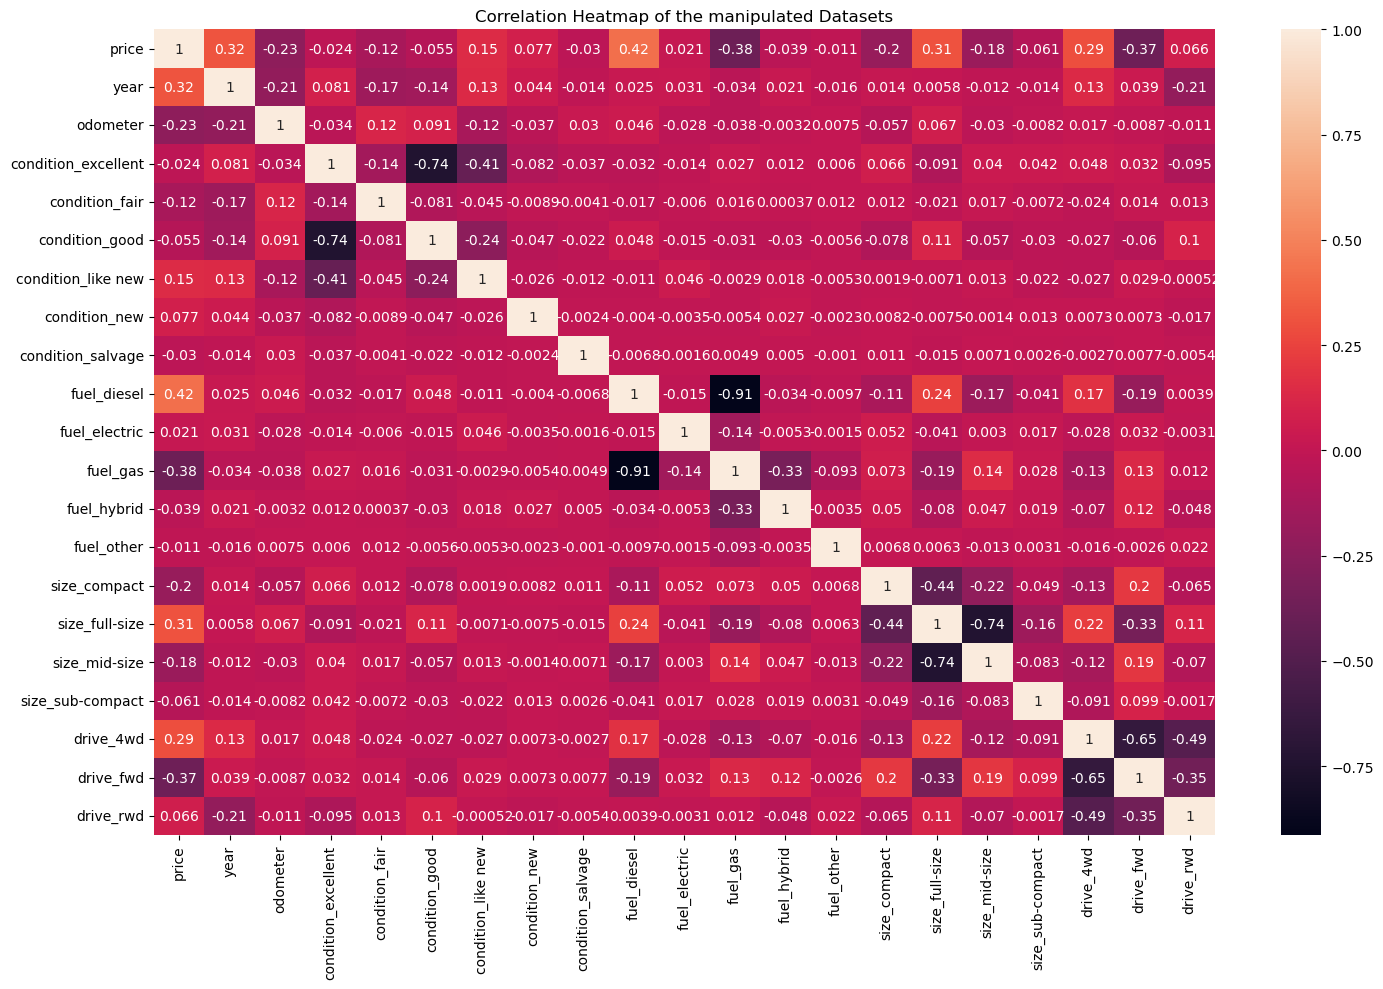

In [179]:
# Heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(model_data_df.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

In [187]:
### Corrrelation Review

# There are some strong correlation between fuel_gas and fuel_diesel, but this is not related to price. 
# Strongest correlation after creating categorical variables is fuel_diesel with price Looking at price, most of the values are negative, 
# the only positive ones are year, condition_like new, fuel_diesel, size_full-size and drive_4wd. 
# The strongest correlation to price is fuel_diesel. Although they are positive numbers, they are not strong correlations that should be considered for 
# removal as the value is less than 0.85

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [189]:

## Lets split the data to training and test sets, 70/30 split ratio so that we can assess how well the model 
## can predict car prices
X = model_data_df.drop(['price'], axis = 1)
y = model_data_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [191]:
#First, we create a new model object. Using fit intercept = false sets the y-intercept to 0.
model=LinearRegression(fit_intercept=False)

In [193]:
# With model created, let's fit the model using the manipulated datasets
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [195]:
# Fitted model can now be used to examine the estimated coefficients and also predict ths value of the dependent
# for a given set of independent variables which in this model is the manipulated dataset
print("Coefficient of the model: ",model.coef_)
print("Intercept of the model: ", model.intercept_)

Coefficient of the model:  [ 4.46704324e+02 -3.09688337e-02 -1.54338713e+05 -1.58651264e+05
 -1.55233917e+05 -1.50690552e+05 -1.41934204e+05 -1.61738600e+05
 -1.72819894e+05 -1.83178464e+05 -1.88680426e+05 -1.87593282e+05
 -1.90315183e+05 -2.33513277e+05 -2.27308162e+05 -2.30570934e+05
 -2.31194877e+05 -3.05095947e+05 -3.12652620e+05 -3.04838683e+05]
Intercept of the model:  0.0


In [197]:
# get the cofficients
[(col, coef) for col, coef in zip (X_train.columns, model.coef_)]

[('year', 446.70432446088745),
 ('odometer', -0.030968833659875017),
 ('condition_excellent', -154338.71260567982),
 ('condition_fair', -158651.263527352),
 ('condition_good', -155233.91745014954),
 ('condition_like new', -150690.5519275711),
 ('condition_new', -141934.2038388255),
 ('condition_salvage', -161738.59994306858),
 ('fuel_diesel', -172819.8938903951),
 ('fuel_electric', -183178.46426226012),
 ('fuel_gas', -188680.42586242835),
 ('fuel_hybrid', -187593.28213744066),
 ('fuel_other', -190315.18314012192),
 ('size_compact', -233513.27694948588),
 ('size_full-size', -227308.16170012904),
 ('size_mid-size', -230570.93408284071),
 ('size_sub-compact', -231194.87656018574),
 ('drive_4wd', -305095.9465458514),
 ('drive_fwd', -312652.62002822664),
 ('drive_rwd', -304838.6827184659)]

In [199]:
#Let compute the predictions for the entire set of inputs
train_predictions=model.predict(X_train)
train_predictions

array([18582.98161611,  8207.71147576, 16212.89413723, ...,
        7693.37587238,  4556.62711211, 16546.25253369])

In [201]:
#Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_train,train_predictions)), 2))

Accuracy:  44.54
RMSE:      9846.1


In [203]:
# Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ",  round(score*100, 2))
print("RMSE:     ",np.sqrt(mean_squared_error(y_train,train_predictions)))

Accuracy:  44.54
RMSE:      9846.098980982806


In [205]:
# Using the model to make predictions of Price on the test set:
test_predictions=model.predict(X_test)

In [207]:
# Compute Accuracy and RMSE to test model
score = model.score(X_test, y_test)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))

Accuracy:  43.09
RMSE:      9941.12


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

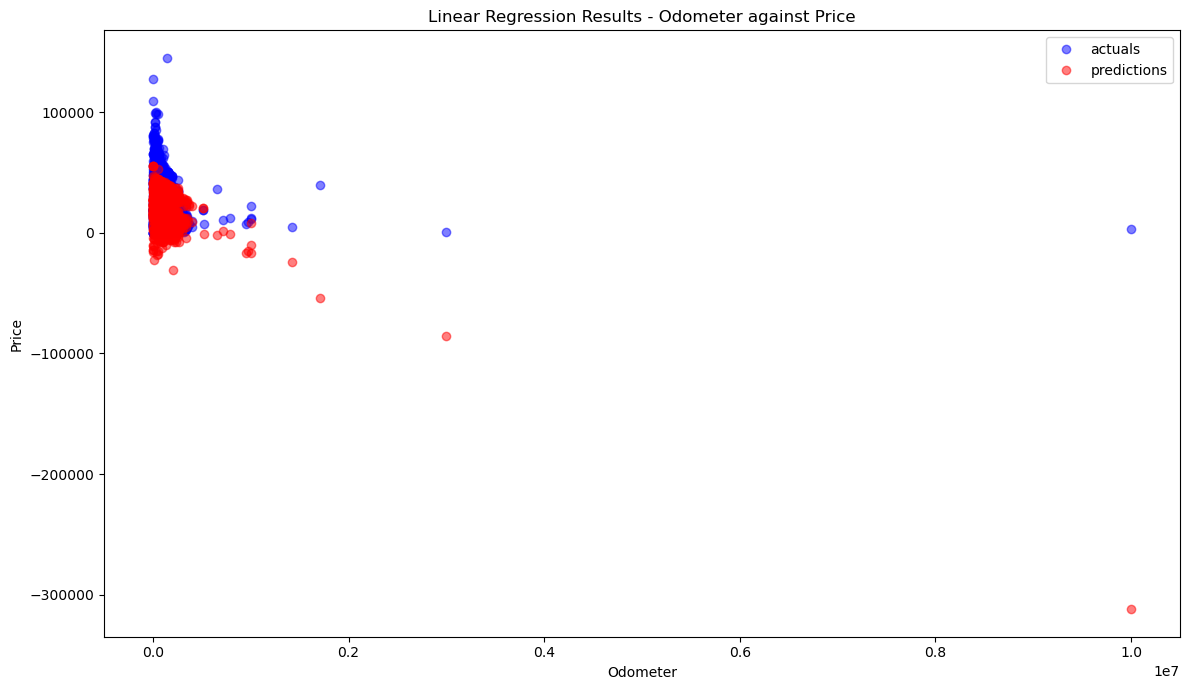

In [209]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.odometer, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.odometer, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

In [211]:
# This visualization of the Linear regression results is not good with negative predictions for Price.

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

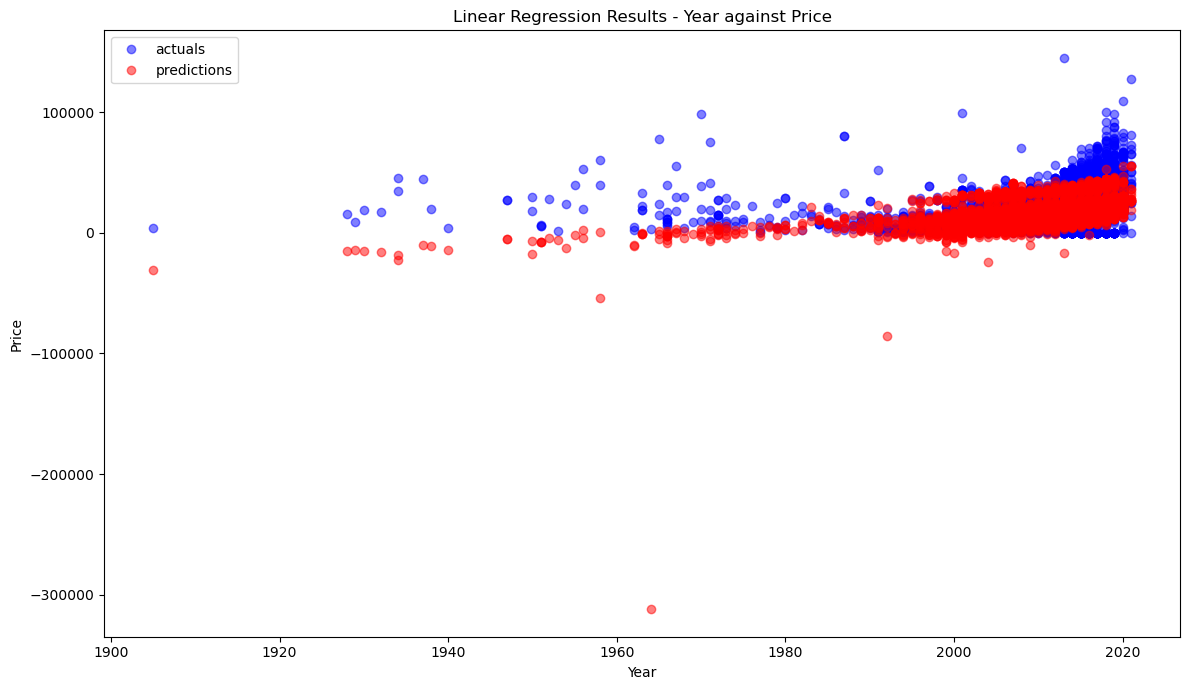

In [213]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.year, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.year, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

In [215]:
# This visualization of the Linear regression results is not good with negative predictions for Price.
# Check the correlation to see if the model tracks the relationship between independent and dependent features
np.corrcoef(y_test, test_predictions) [0][1]

0.6586628004709668

In [217]:
# With a number of 0.65 for correlation coefficiency and 43.09 for accuracy, this shows that the 
# predictions are not strongly correlated

In [219]:
#Prediction using all input values as parameters

#First Example, new car with 100 miles, condition excellent and new with diesel and four wheel drive
new_car_with_all_strong_features = [[2022,100,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0]]
print("New car with 100 miles, condition excellent and new with diesel and four wheel drive: ", model.predict(new_car_with_all_strong_features))

#Second Example, new car with 100 miles, condition good and with Electric and front wheel drive
new_ev_car_with_some_features = [[2022,100,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0]]
print("New car with 100 miles, condition good and with Electric and front wheel drive ", model.predict(new_ev_car_with_some_features))

New car with 100 miles, condition excellent and new with diesel and four wheel drive:  [-98263.87140433]
New car with 100 miles, condition good and with Electric and front wheel drive  [29013.33885829]


In [221]:
## Issue with outliers and bad data if a new 2022 car with 100 miles is priced at -$98,263 and a new 2022 EV car is 
## priced at $29,013

In [223]:
# Model1 application will be created using odometer and year in the final dataset

# Run Regression using Odometer and Year for Price Prediction
X1 = model_data_df[['odometer', 'year']]
y1 = model_data_df.price
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 0)
model1=LinearRegression(fit_intercept=False)
model1.fit(X1_train, y1_train)
print("Coefficient of the model: ",model1.coef_)
print("Intercept of the model: ", model1.intercept_)

Coefficient of the model:  [-0.03699603 10.44305147]
Intercept of the model:  0.0


In [225]:
# get the cofficients
[(col, coef) for col, coef in zip (X1_train.columns, model1.coef_)]

[('odometer', -0.0369960341290061), ('year', 10.443051473587191)]

In [227]:
#Let compute the predictions for the entire set of inputs
train1_predictions=model1.predict(X1_train)
train1_predictions

array([17897.98500006, 15852.21161747, 15868.32803513, ...,
       17706.36219961, 16074.96473896, 15720.33372877])

In [229]:
#Compute Accuracy and RMSE to training model
score1 = model1.score(X1_train, y1_train)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y1_train,train1_predictions)), 2))

Accuracy:  6.94
RMSE:      12753.69


In [231]:
# Using the model to make predictions of Price on the test set:
test1_predictions=model1.predict(X1_test)

In [233]:
# Compute Accuracy and RMSE to test model
score1 = model1.score(X1_test, y1_test)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))

Accuracy:  1.92
RMSE:      9941.12


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

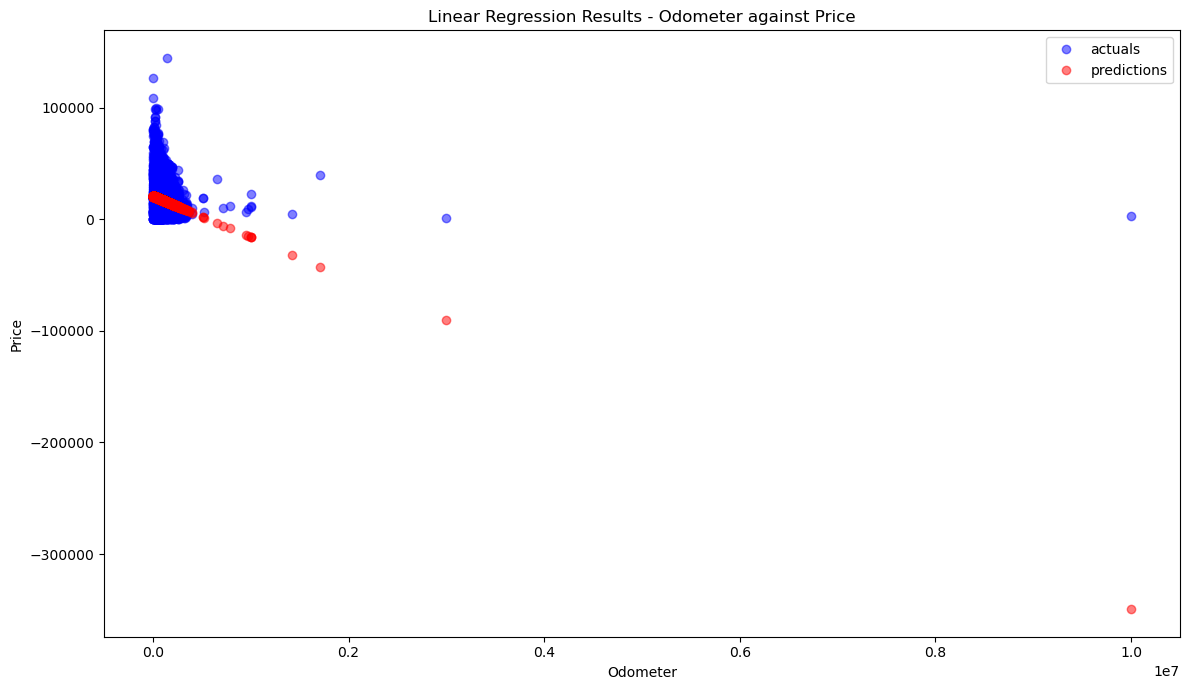

In [235]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X1_test.odometer, y1_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X1_test.odometer, test1_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

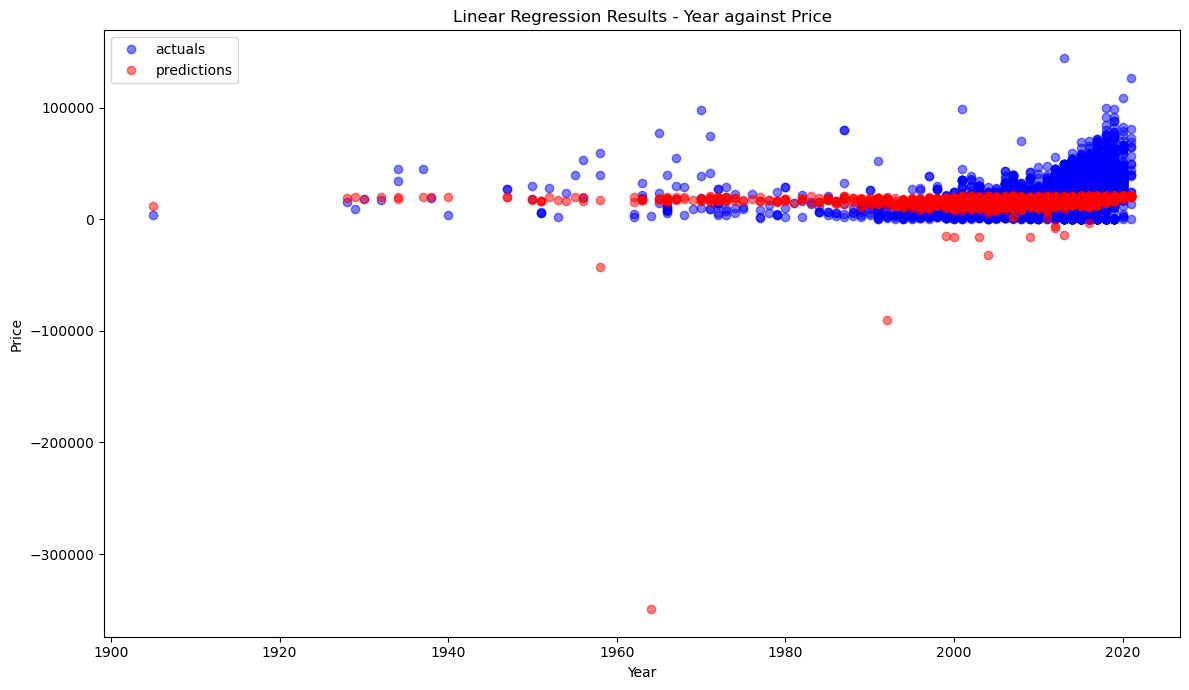

In [237]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X1_test.year, y1_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X1_test.year, test1_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

In [239]:
# The linear regression model results do not produce a model that can be used for Price Prediction. 
# I could look at some of the other categorical variables like condition, fuel, size etc, but I suspect that the result could be 
# the same because of the bad data for Price.

# Let's evaluate using mean and median of the Odometer and Price to see if we can updates these values

In [241]:
#Prediction using all input values as parameters

#First Example, new car with 100 miles with Year of 2022
new_car_2022 = [[100,2022]]
print("New car with 100 miles: ", model1.predict(new_car_2022))

#Second Example, old car with 90000 miles with year of 2001
old_car_2001 = [[90000,2001]]
print("Old 2001 car with 90000 miles: ", model1.predict(old_car_2001))

New car with 100 miles:  [21112.15047618]
Old 2001 car with 90000 miles:  [17566.90292704]


In [243]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target. 
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively. 
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.

train1_mses = []
test1_mses = []
best_model_complexity1 = ''

for i in range(1, 7):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
    pipe.fit(X1_train, y1_train)
    train1_preds = pipe.predict(X1_train)
    test1_preds = pipe.predict(X1_test)
    train1_mses.append(mean_squared_error(y1_train, train1_preds))
    test1_mses.append(mean_squared_error(y1_test, test1_preds))
    
best_model_complexity1 = test1_mses.index(min(test1_mses)) + 1

print(len(train1_mses))
print(np.round(train1_mses, 2))
print(len(test1_mses))
print(np.round(test1_mses, 2))
print(best_model_complexity1)

6
[1.51171769e+08 1.29280259e+08 1.38196852e+08 1.35527990e+08
 1.42654209e+08 1.69846673e+08]
6
[1.54860845e+08 1.32683199e+08 8.38242532e+08 8.35735519e+11
 2.71602646e+12 2.93840437e+14]
2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 132683199.33200964


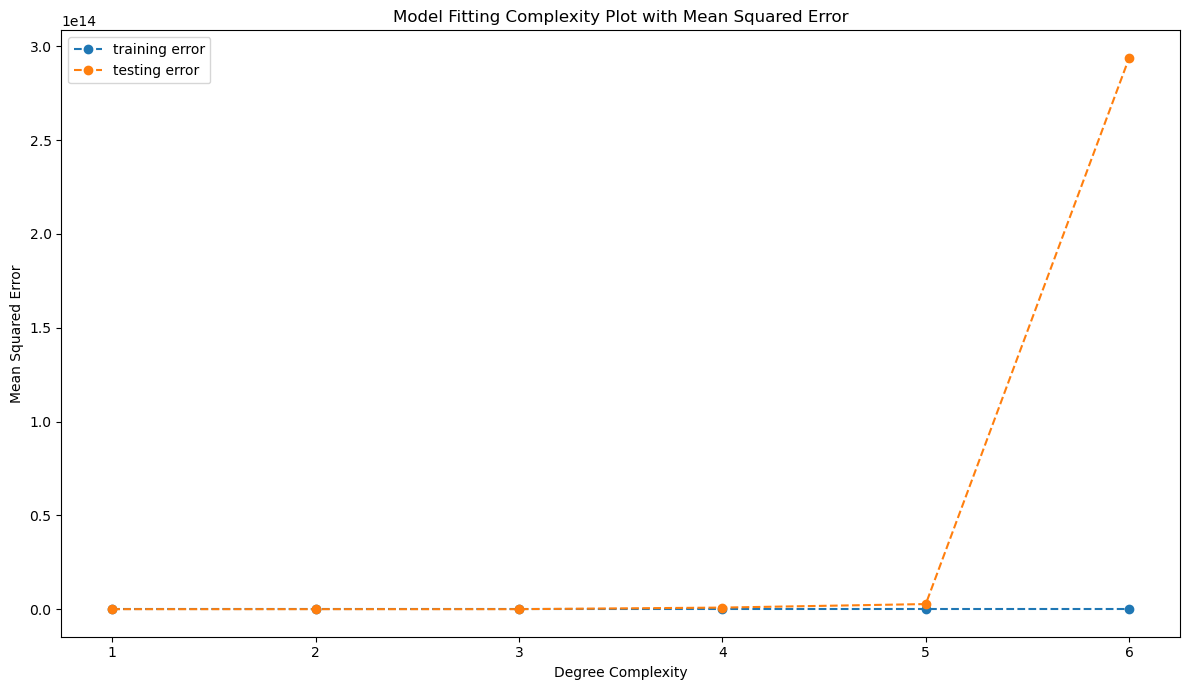

In [245]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test1_mses.index(min(test1_mses)) + 1}')
print(f'The minimal MSE was: {min(test1_mses)}')
plt.figure(figsize =(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 7), train1_mses, '--o', label = 'training error')
plt.plot(range(1, 7), test1_mses, '--o', label = 'testing error')
plt.xticks(range(1, 7), range(1, 7))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [247]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

modelR = Ridge(alpha=1e-2).fit(X1_train, y1_train)
modelR.score(X1_test, y1_test)


0.10815754698101976

In [249]:
#  permutation_importance function to probe which features are most predictive
r = permutation_importance(modelR, X1_test, y1_test, n_repeats=30, random_state=0)

In [251]:
# mean values for permutation_importance
perm_df = pd.Series(r.importances_mean, index=X1_test.columns).sort_values(ascending=False)
perm_df

year        0.148678
odometer    0.072991
dtype: float64

Text(0.5, 0, 'Dataset Columns')

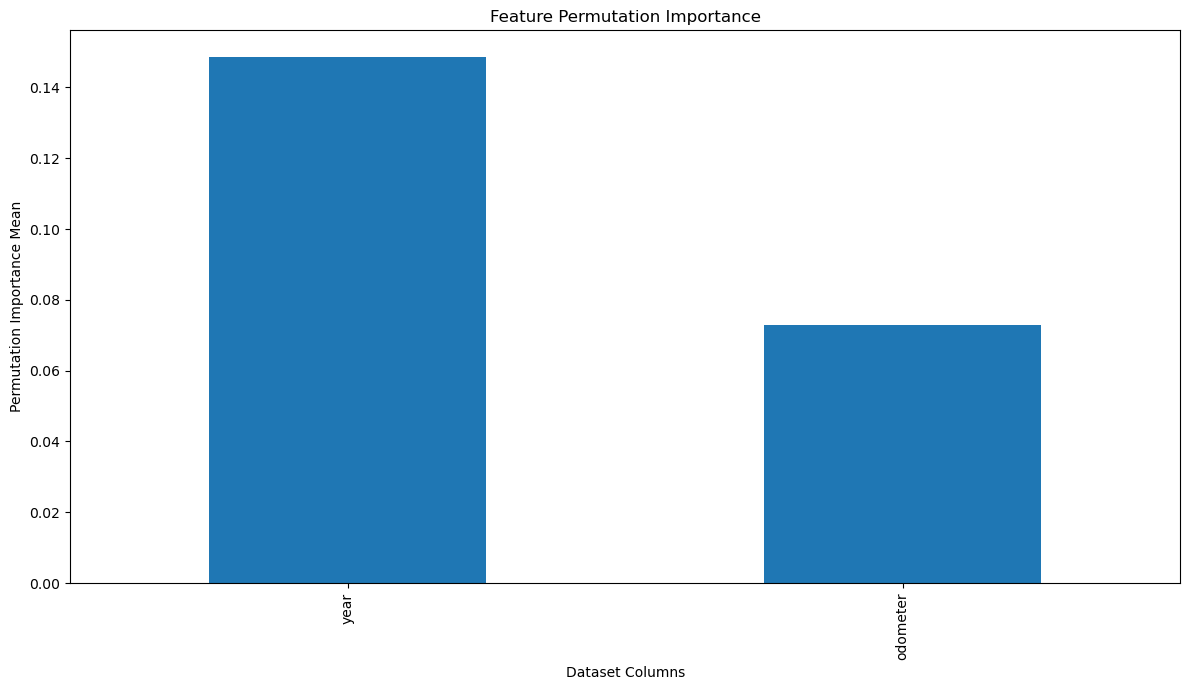

In [253]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df.plot.bar(x=X1_test.columns, y=r.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Dataset Columns")

In [255]:
# Looking a the Bar Plot, year is more important than odometer. Also all the models was built using 
# LinearRegression(fit_intercept=False) so that the fit_intercept=False sets the y-intercept to 0, i.e., 
# the intercept is forced to the origin (0, 0).

# Using fit_intercept=False provided predictions that minimized the number of negative points for Prices

In [257]:
# Let start by copying the data
new_car_data_df = model_data_df.copy()
new_car_data_df

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
219,2500,1995.0,110661.0,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
338,4000,1972.0,88100.0,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,146795.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False
426788,12995,2016.0,61127.0,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False
426792,32999,2014.0,154642.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
426793,15999,2018.0,36465.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


In [259]:
# mean Odometer
print('The mean of "Odometer" is %.2f' %(new_car_data_df["odometer"].mean(skipna=True)))
# median Odometer
print('The median of "Odometer" is %.2f' %(new_car_data_df["odometer"].median(skipna=True)))

The mean of "Odometer" is 109198.25
The median of "Odometer" is 105722.00


In [261]:
# mean Price
print('The mean of "Price" is %.2f' %(new_car_data_df["price"].mean(skipna=True)))
# median Price
print('The median of "Price" is %.2f' %(new_car_data_df["price"].median(skipna=True)))

The mean of "Price" is 16982.50
The median of "Price" is 13000.00


In [263]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
s = new_car_data_df.lt(1000).any()
s

price                   True
year                   False
odometer                True
condition_excellent     True
condition_fair          True
condition_good          True
condition_like new      True
condition_new           True
condition_salvage       True
fuel_diesel             True
fuel_electric           True
fuel_gas                True
fuel_hybrid             True
fuel_other              True
size_compact            True
size_full-size          True
size_mid-size           True
size_sub-compact        True
drive_4wd               True
drive_fwd               True
drive_rwd               True
dtype: bool

In [265]:
# As you can see there are values less than 5000 for price and odometer for use cars. Odometer may be realistic 
# as there are 2020 cars
# We make the assumption that all car entries with values of 5000 for Price and Odometer are not valid records
# Remove this records from the Dataset

In [267]:
# Remove records with Odometer and Price less than 5000
new_car_data_df1 = new_car_data_df.query("odometer > 5000 and price > 5000")
new_car_data_df1

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
346,98900,2001.0,20187.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
355,9400,2008.0,129473.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
364,7300,2007.0,181000.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,146795.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False
426788,12995,2016.0,61127.0,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False
426792,32999,2014.0,154642.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
426793,15999,2018.0,36465.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


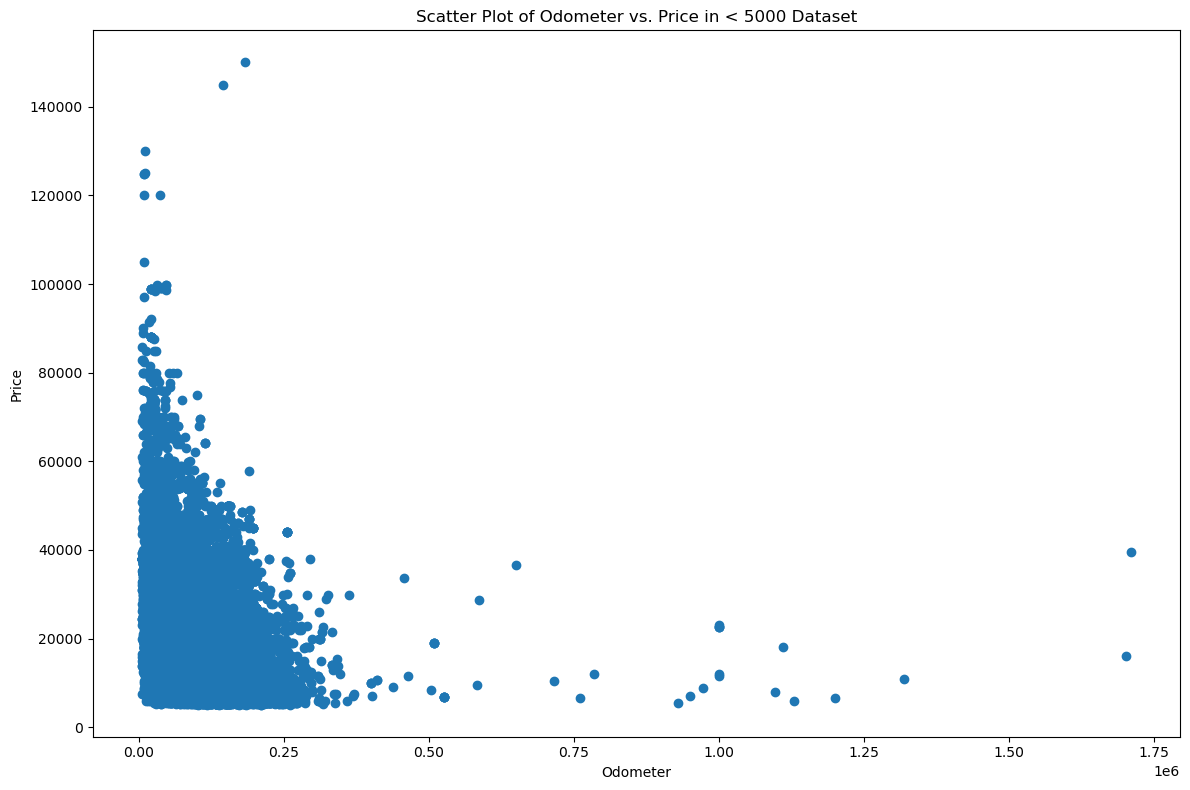

In [269]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(new_car_data_df1['odometer'], new_car_data_df1['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in < 5000 Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

In [271]:
#Some visualizations to review the updated datasets

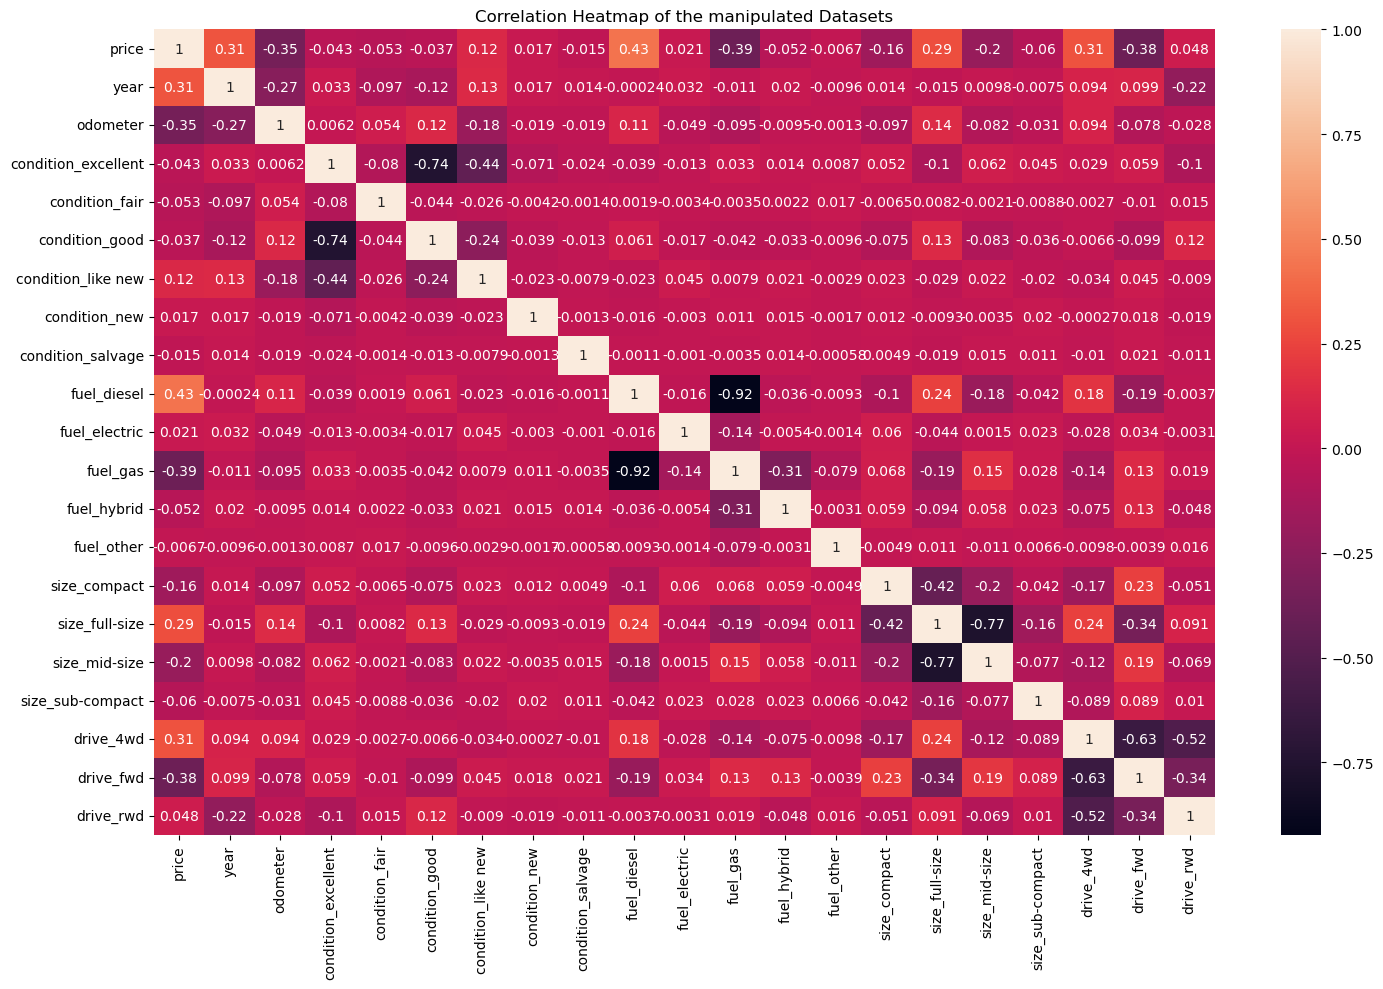

In [273]:
# heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(new_car_data_df1.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

In [275]:
# Model2 application will be created using odometer and year in the dataset with "odometer > 5000 and price > 5000"

In [277]:
# Run Regression using Odometer and Year for Price Prediction
X2 = new_car_data_df1[['odometer', 'year']]
y2 = new_car_data_df1.price
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)
model2=LinearRegression(fit_intercept=False)
model2.fit(X2_train, y2_train)
print("Coefficient of the model: ",model2.coef_)
print("Intercept of the model: ", model2.intercept_)

Coefficient of the model:  [-0.07321818 13.17246703]
Intercept of the model:  0.0


In [279]:
# get the cofficients
[(col, coef) for col, coef in zip (X2_train.columns, model2.coef_)]

[('odometer', -0.07321818401652598), ('year', 13.172467028829177)]

In [281]:
#Let compute the predictions for the entire set of inputs
train2_predictions=model2.predict(X2_train)
train2_predictions

array([21072.97628069, 24074.24244343, 11001.2769664 , ...,
       17645.90038409, 20214.05376399, 16752.98421172])

In [283]:
#Compute Accuracy and RMSE to training model
score2 = model2.score(X2_train, y2_train)
print("Accuracy: ", round(score2*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y2_train,train2_predictions)), 2))

Accuracy:  12.45
RMSE:      11667.56


In [285]:
# Using the model to make predictions of Price on the test set:
test2_predictions=model2.predict(X2_test)

In [287]:
# Compute Accuracy and RMSE to test model
score2 = model2.score(X2_test, y2_test)
print("Accuracy: ", round(score2*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y2_test,test2_predictions)), 2))

Accuracy:  12.54
RMSE:      11930.52


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

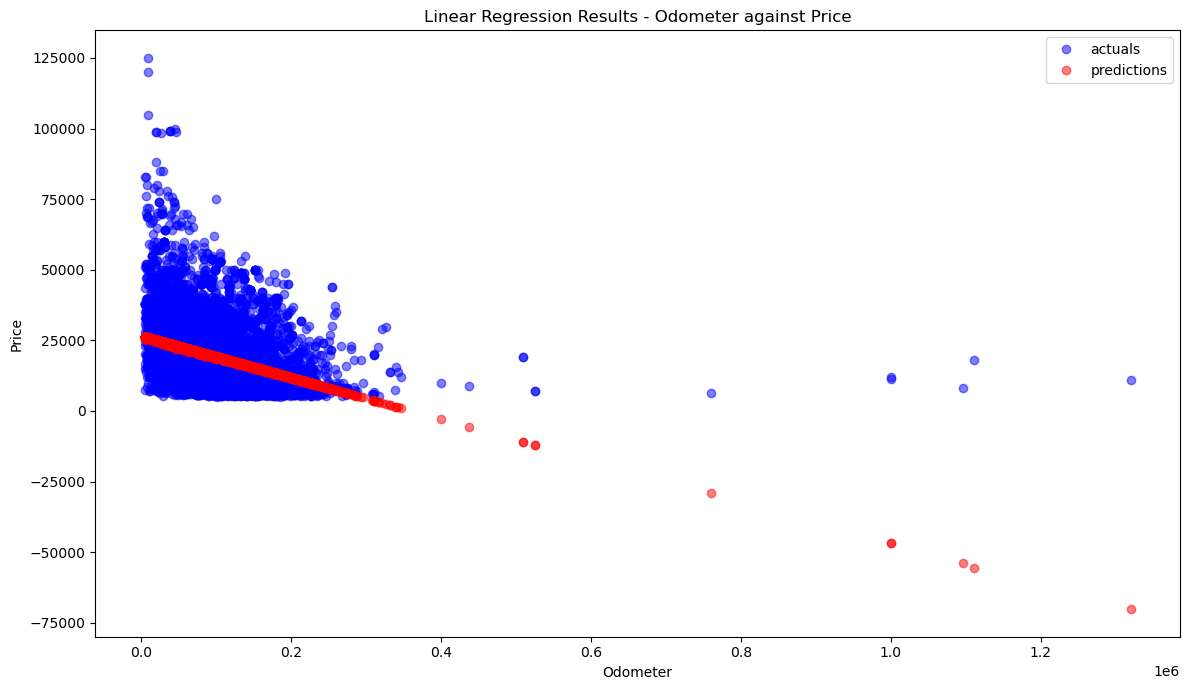

In [289]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X2_test.odometer, y2_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X2_test.odometer, test2_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

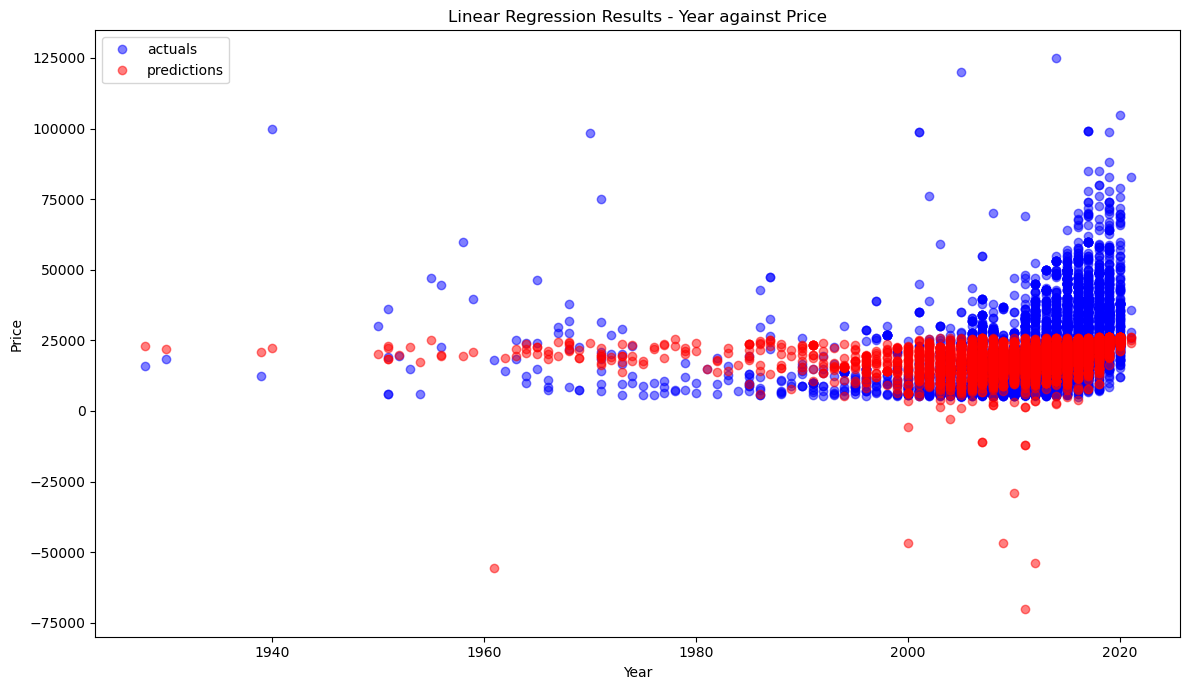

In [291]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X2_test.year, y2_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X2_test.year, test2_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

In [293]:
#Prediction using Odometer and year as an input value
new_car = [[100, 2022]]
print("New 2022 Car with 100 miles ", model2.predict(new_car))

New 2022 Car with 100 miles  [26627.40651389]


In [295]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target. 
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively. 
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.

train2_mses = []
test2_mses = []
best2_model_complexity = ''

for i in range(1, 7):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
    pipe.fit(X2_train, y2_train)
    train2_preds = pipe.predict(X2_train)
    test2_preds = pipe.predict(X2_test)
    train2_mses.append(mean_squared_error(y2_train, train2_preds))
    test2_mses.append(mean_squared_error(y2_test, test2_preds))
    
best2_model_complexity = test2_mses.index(min(test2_mses)) + 1

print(len(train2_mses))
print(np.round(train2_mses, 2))
print(len(test2_mses))
print(np.round(test2_mses, 2))
print(best2_model_complexity)

6
[1.28648276e+08 1.14358819e+08 1.12537038e+08 1.17756719e+08
 1.16665864e+08 1.25311878e+08]
6
[1.34926745e+08 1.20747774e+08 1.19996314e+08 1.25326684e+08
 1.32031264e+08 1.34303921e+08]
3


The Complexity that minimized Test Error was: 3
The minimal MSE was: 119996314.21369706


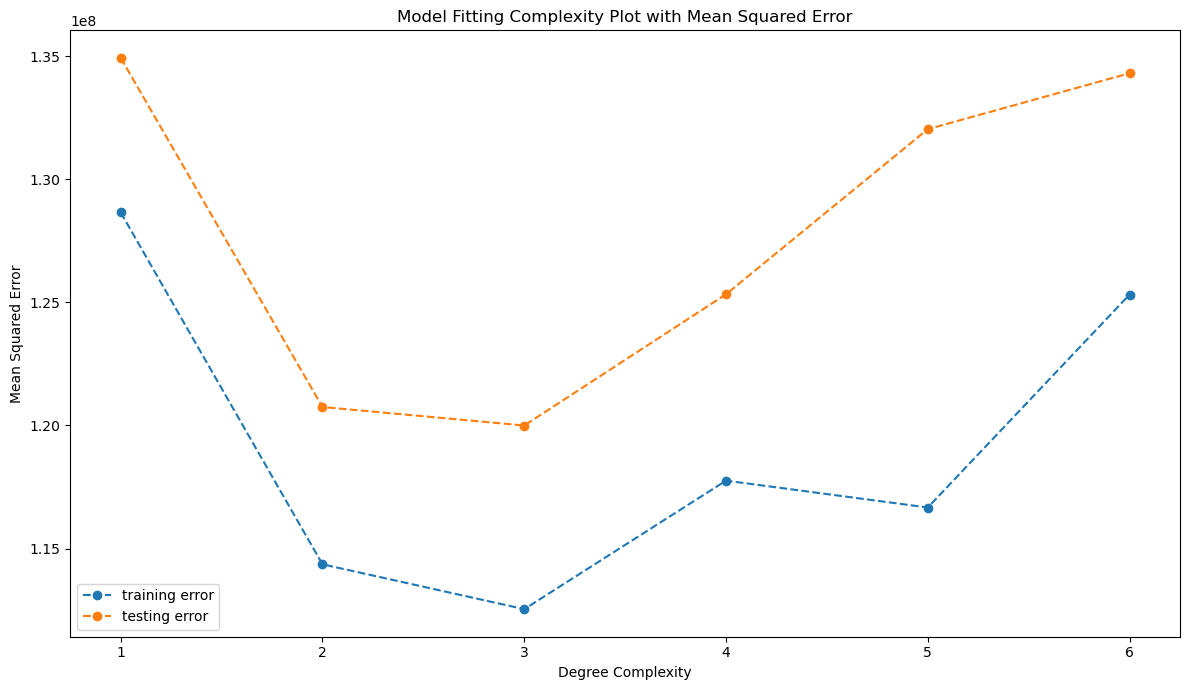

In [297]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test2_mses.index(min(test2_mses)) + 1}')
print(f'The minimal MSE was: {min(test2_mses)}')
plt.figure(figsize =(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 7), train2_mses, '--o', label = 'training error')
plt.plot(range(1, 7), test2_mses, '--o', label = 'testing error')
plt.xticks(range(1, 7), range(1, 7))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [299]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model2 = Ridge(alpha=1e-2).fit(X2_train, y2_train)
model2.score(X2_test, y2_test)

0.17096228389491885

In [301]:
#  permutation_importance function to probe which features are most predictive
r2 = permutation_importance(model2, X2_test, y2_test, n_repeats=30, random_state=0)

In [303]:
# mean values for permutation_importance
perm_df = pd.Series(r2.importances_mean, index=X2_test.columns).sort_values(ascending=False)
perm_df

odometer    0.159575
year        0.110169
dtype: float64

In [305]:
# Based on this permutation importance result, odometer is more important than year

In [307]:
# Model3 application will be created using year in the dataset with "odometer > 5000 and price > 5000"

# Let's run regression models using other features like year and odometer to see if there is any Strong correlation

Coefficient of the model:  [9.36367277]
Intercept of the model:  0.0
Accuracy:  0.3
RMSE:      12450.35
Accuracy:  0.26
RMSE:      12741.11


Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

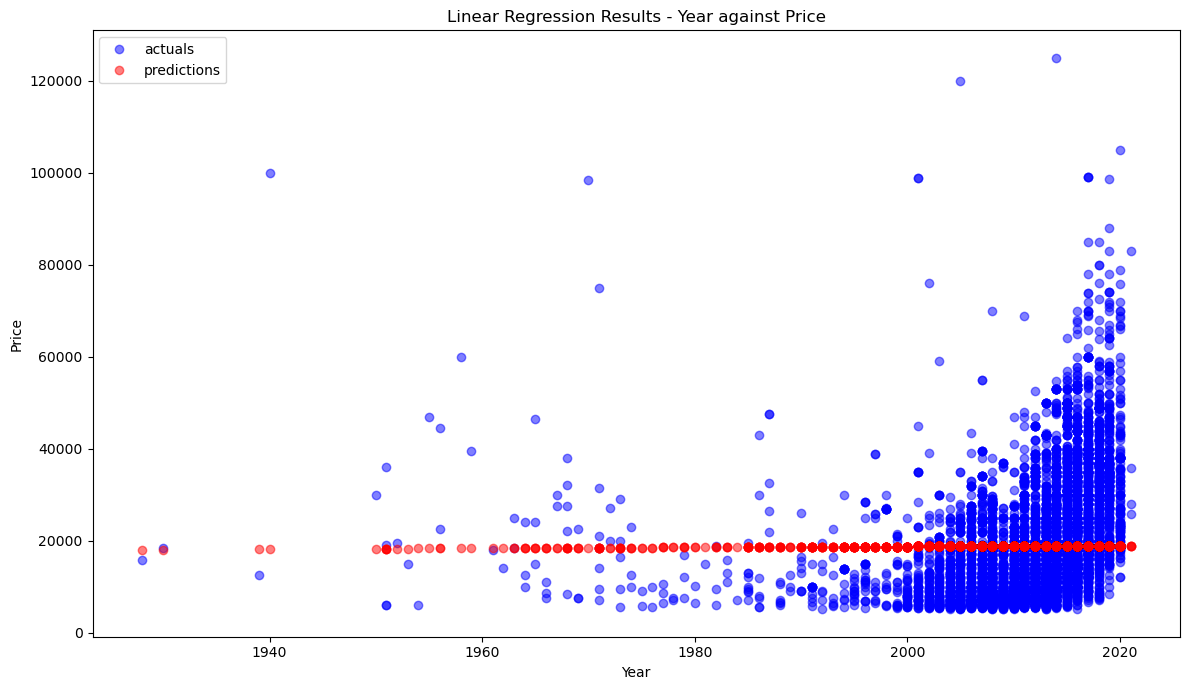

In [309]:
# Run Regression using year for Price Prediction
X3 = new_car_data_df1[['year']]
y3 = new_car_data_df1.price
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.3, random_state = 0)
model3=LinearRegression(fit_intercept=False)
model3.fit(X3_train, y3_train)
print("Coefficient of the model: ",model3.coef_)
print("Intercept of the model: ", model3.intercept_)

#Let compute the predictions for the entire set of inputs
train3_predictions=model3.predict(X3_train)

#Compute Accuracy and RMSE to training model
score3 = model3.score(X3_train, y3_train)
print("Accuracy: ", round(score3*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_train,train3_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test3_predictions=model3.predict(X3_test)

# Compute Accuracy and RMSE to test model
score3 = model3.score(X3_test, y3_test)
print("Accuracy: ", round(score3*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_test,test3_predictions)), 2))

# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X3_test.year, y3_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X3_test.year, test3_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

In [311]:
#Prediction using Year as a value
print("Car with Year of 1940:  ", model3.predict([[1940]]))
print("Car with Year of 1980:  ", model3.predict([[1980]]))
print("Car with Year of 2020:  ", model3.predict([[2020]]))
print("Car with Year of 2023:  ", model3.predict([[2023]]))

Car with Year of 1940:   [18165.5251721]
Car with Year of 1980:   [18540.07208287]
Car with Year of 2020:   [18914.61899363]
Car with Year of 2023:   [18942.71001194]


In [313]:
# Model4 application will be created using odometer in the dataset with "odometer > 5000 and price > 5000"

Coefficient of the model:  [0.11838402]
Intercept of the model:  0.0
Accuracy:  -97.45
RMSE:      17521.26
Accuracy:  -96.91
RMSE:      17901.61


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

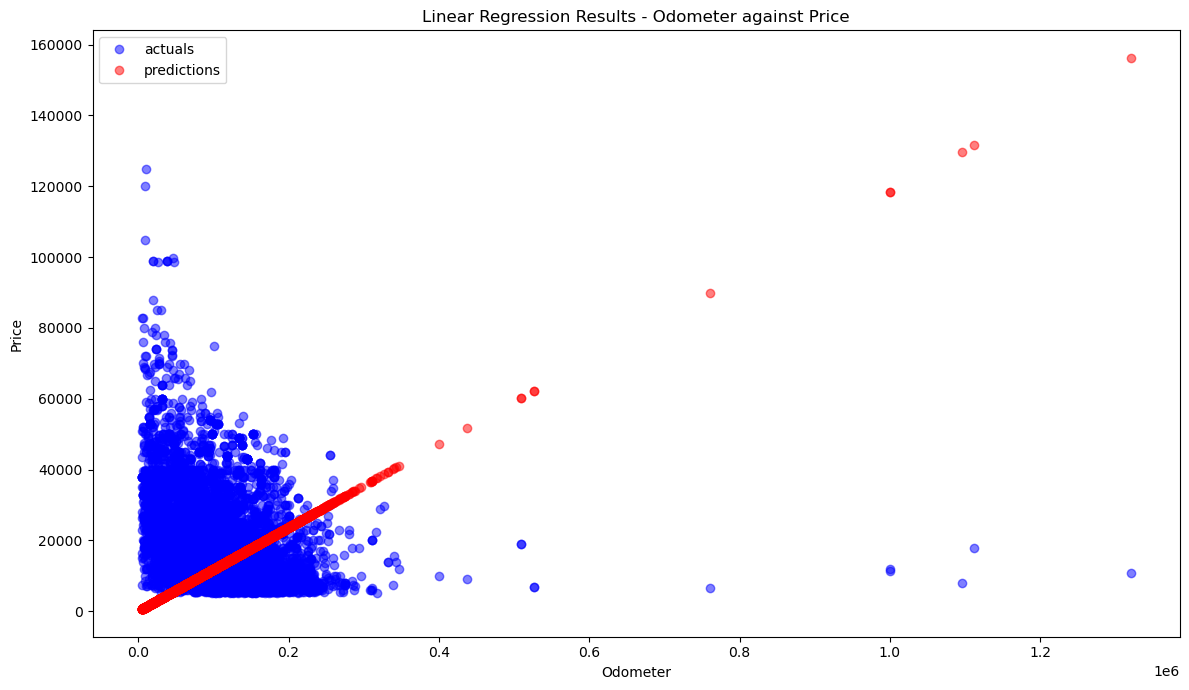

In [315]:
# Run Regression using odometer for Price Prediction
X4 = new_car_data_df1[['odometer']]
y4 = new_car_data_df1.price
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.3, random_state = 0)
model4=LinearRegression(fit_intercept=False)
model4.fit(X4_train, y4_train)
print("Coefficient of the model: ",model4.coef_)
print("Intercept of the model: ", model4.intercept_)

#Let compute the predictions for the entire set of inputs
train4_predictions=model4.predict(X4_train)

#Compute Accuracy and RMSE to training model
score4 = model4.score(X4_train, y4_train)
print("Accuracy: ", round(score4*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y4_train,train4_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test4_predictions=model4.predict(X4_test)

# Compute Accuracy and RMSE to test model
score4 = model4.score(X4_test, y4_test)
print("Accuracy: ", round(score4*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y4_test,test4_predictions)), 2))

# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X4_test.odometer, y4_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X4_test.odometer, test4_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

In [317]:
#Prediction using Odometer as an input value
print("Car with Odometer of 10000:  ", model4.predict([[10000]]))
print("Car with Odometer of 50000:  ", model4.predict([[50000]]))
print("Car with Odometer of 90000:  ", model4.predict([[90000]]))
print("Car with Odometer of 100000:  ", model4.predict([[100000]]))

Car with Odometer of 10000:   [1183.84017086]
Car with Odometer of 50000:   [5919.20085429]
Car with Odometer of 90000:   [10654.56153773]
Car with Odometer of 100000:   [11838.40170858]


In [321]:
# Model5 application will be created using the full features in the dataset with "odometer > 5000 and price > 5000" to observe 
# the complexity of the model using OneHotEncoder vs get_dummies to convert categorical variable into dummy/indicator variables

In [323]:
# Using OneHotEncoder and permutation importance to determine the main features that impact used car prices
data_copy1 = data_copy.query("odometer > 5000 and price > 5000")
data_copy1.head()

,price,year,condition,fuel,odometer,drive,size
268,9000,2008.0,excellent,gas,56700.0,rwd,compact
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size
346,98900,2001.0,good,gas,20187.0,rwd,mid-size
355,9400,2008.0,good,gas,129473.0,rwd,full-size
364,7300,2007.0,good,gas,181000.0,fwd,mid-size


In [325]:
data_copy1.describe()

,price,year,odometer
count,27816.000000,27816.000000,2.781600e+04
mean,18910.265926,2011.626043,1.047101e+05
std,12557.334892,6.615416,5.932711e+04
min,5100.000000,1927.000000,5.011000e+03
25%,9500.000000,2009.000000,6.691875e+04
50%,14995.000000,2013.000000,1.021260e+05
75%,24990.000000,2016.000000,1.369650e+05
max,150000.000000,2021.000000,1.710000e+06


In [327]:
X5 = data_copy1.drop(columns='price')
y5 = data_copy1['price']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.3, random_state = 0)

In [329]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target. 
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively. 
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.
# Also using OneHotEncoder as oppose to get_dummies to see if there are any difference in results
feature_cols = ['odometer', 'year']
train_mses = []
test_mses = []

best_mse = np.inf
best_pipe = None

for i in range (1, 10):
    col_transformer = make_column_transformer ((OneHotEncoder(), ['condition','fuel','drive','size']),
                                              (PolynomialFeatures(degree = i, include_bias=False), feature_cols), 
                                               remainder='passthrough')
    pipe = Pipeline([
        ('col_transformer', col_transformer),
        ('model', LinearRegression())
    ])
    
    pipe.fit(X5_train, y5_train)

    
    train_preds = pipe.predict(X5_train)
    test_preds = pipe.predict(X5_test)
    train_mses.append(mean_squared_error(train_preds, y5_train))
    test_mse = mean_squared_error(test_preds, y5_test)
    if test_mse < best_mse:
        best_mse = test_mse
        best_pipe = pipe
    test_mses.append(test_mse)
     
best_model_complexity = test_mses.index(min(test_mses)) + 1

print(len(train_mses))
print(np.round(train_mses, 2))
print(len(test_mses))
print(np.round(test_mses, 2))
print(best_model_complexity)

9
[7.21384200e+07 5.83762339e+07 1.12537522e+08 1.17756721e+08
 1.16665871e+08 1.25346937e+08 1.39753130e+08 1.46887645e+08
 1.52249860e+08]
9
[7.44246068e+07 6.12120362e+07 1.20019447e+08 1.25328776e+08
 1.32033822e+08 1.34442696e+08 1.80118245e+08 2.30635961e+08
 3.00864452e+08]
2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 61212036.2097872


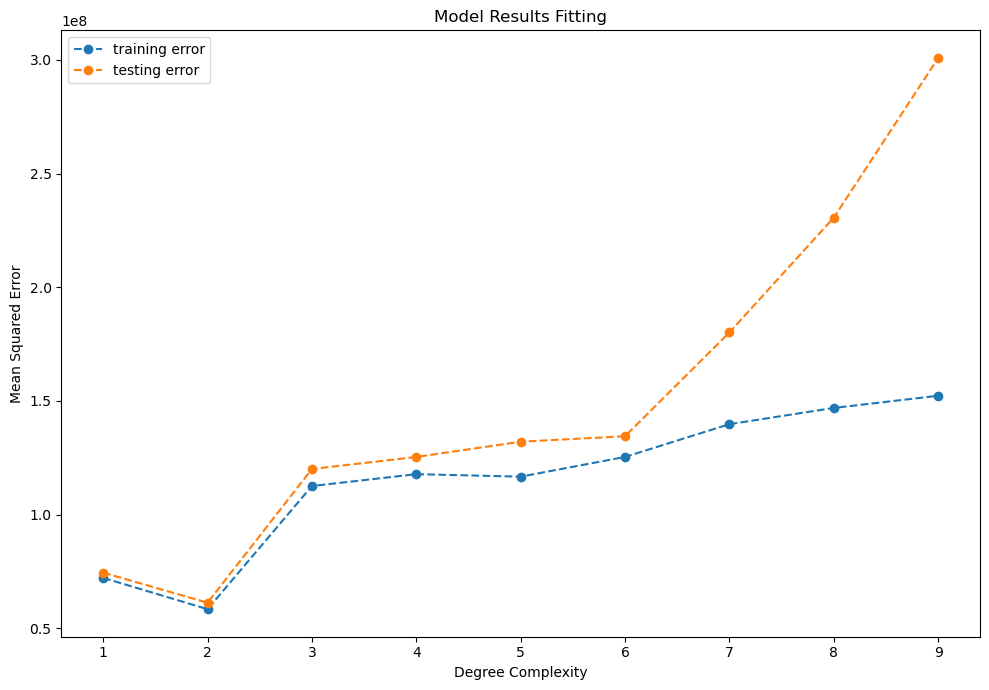

In [331]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The minimal MSE was: {min(test_mses)}')
plt.figure(figsize=(10, 7))
plt.plot(range(1, 10), train_mses, '--o', label = 'training error')
plt.plot(range(1, 10), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 10), range(1, 10))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.title('Model Results Fitting')
plt.legend();

In [333]:
# The Complexity that minimized Test Error value of 2 is similar/exact to some of the Model applications above, 
# so it does not look like there is a difference between using OneHotEncoder vs. get_dummies to onvert categorical variable 
# into dummy/indicator variables

In [335]:
#permutation_importance function to probe which features are most predictive
#r = permutation_importance(best_pipe, X_test, y_test)

In [339]:
# Model6 application will be created using the features that have a better correlation with price in the dataset with 
# "odometer > 5000 and price > 5000". These features are odometer, year, fuel_diesel, drive_4wd and size_full-size

In [341]:
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X6 = new_car_data_df1[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y6 = new_car_data_df1.price
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.3, random_state = 0)
model6=LinearRegression(fit_intercept=False)
model6.fit(X6_train, y6_train)
print("Coefficient of the model: ",model6.coef_)
print("Intercept of the model: ", model6.intercept_)

#Let compute the predictions for the entire set of inputs
train6_predictions=model6.predict(X6_train)

#Compute Accuracy and RMSE to training model
score6 = model6.score(X6_train, y6_train)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_train,train6_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test6_predictions=model6.predict(X6_test)

# Compute Accuracy and RMSE to test model
score6 = model6.score(X6_test, y6_test)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_test,test6_predictions)), 2))

Coefficient of the model:  [-9.29055281e-02  1.03483761e+01  1.63674361e+04  5.73780578e+03
  5.37707748e+03]
Intercept of the model:  0.0
Accuracy:  45.26
RMSE:      9226.0
Accuracy:  46.88
RMSE:      9298.39


In [343]:
## Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full_size as input


print("Car with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ", model6.predict([[100000,1990,1,1,1]]))
print("Car with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ", model6.predict([[100000,1990,0,1,1]]))

print("Car with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ", model6.predict([[10000,2020,1,1,1]]))
print("Car with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ", model6.predict([[10000,2020,0,1,1]]))

Car with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size:  [38785.03501702]
Car with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size:  [22417.5988814]
Car with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size:  [47456.98382732]
Car with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size:  [31089.5476917]


In [345]:

#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model6R = Ridge(alpha=1e-2).fit(X6_train, y6_train)
model6R.score(X6_test, y6_test)

0.49799687562124473

In [347]:
#  permutation_importance function to probe which features are most predictive
r6 = permutation_importance(model6R, X6_test, y6_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df6 = pd.Series(r6.importances_mean, index=X6_test.columns).sort_values(ascending=False)
perm_df6

fuel_diesel       0.306407
odometer          0.299662
drive_4wd         0.086750
size_full-size    0.086642
year              0.072825
dtype: float64

Text(0.5, 0, 'Car Features')

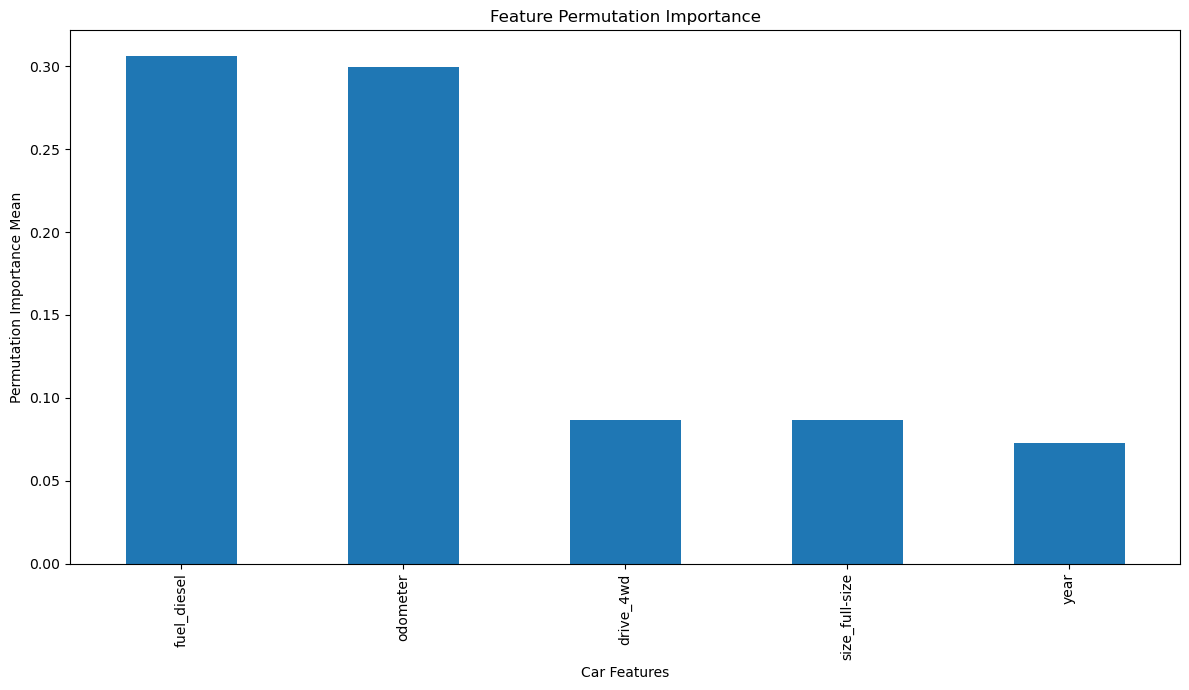

In [349]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df6.plot.bar(x=X6_test.columns, y=r6.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Car Features")

In [351]:
# Create a new dataframe with used cars from 1990 onwards
new_car_data_1990_df = new_car_data_df1.query("year > 1990")
new_car_data_1990_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
346,98900,2001.0,20187.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
355,9400,2008.0,129473.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
364,7300,2007.0,181000.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


In [353]:
# Number of the records in the dataset
new_car_data_1990_df.shape

(27444, 21)

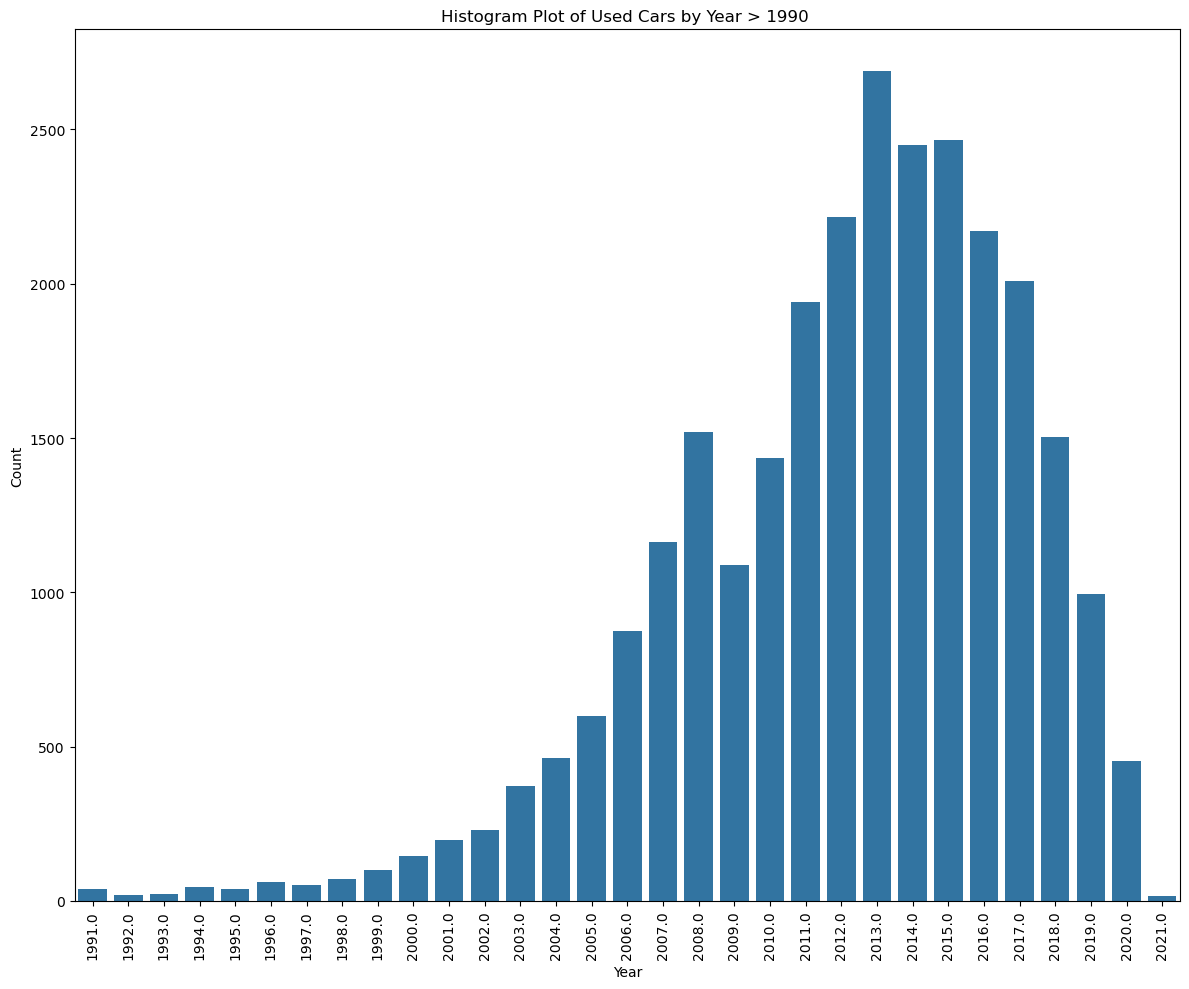

In [355]:
# Plot the number of used car counts by year after filtering records to > 1900

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='year', data=new_car_data_1990_df , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Year > 1990 ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.show()

In [357]:
# Model7 application will be created using the features that have a better correlation with price in the dataset with 
# "odometer > 5000 and price > 5000" and year > 1990. These features are odometer, year, fuel_diesel, drive_4wd and size_full-size

In [359]:
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X7 = new_car_data_1990_df[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y7 = new_car_data_1990_df.price
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = 0.3, random_state = 0)
model7=LinearRegression(fit_intercept=False)
model7.fit(X7_train, y7_train)
print("Coefficient of the model: ",model7.coef_)
print("Intercept of the model: ", model7.intercept_)

#Let compute the predictions for the entire set of inputs
train7_predictions=model7.predict(X7_train)

#Compute Accuracy and RMSE to training model
score7 = model7.score(X7_train, y7_train)
print("Accuracy: ", round(score7*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y7_train,train7_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test7_predictions=model7.predict(X7_test)

# Compute Accuracy and RMSE to test model
score7 = model7.score(X7_test, y7_test)
print("Accuracy: ", round(score7*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y7_test,test7_predictions)), 2))

Coefficient of the model:  [-9.79393406e-02  1.05400863e+01  1.65377878e+04  5.88123006e+03
  5.50763744e+03]
Intercept of the model:  0.0
Accuracy:  47.52
RMSE:      9089.08
Accuracy:  48.26
RMSE:      8970.29


In [361]:
## Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full_size as input


print("Car with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ", model7.predict([[100000,1990,1,1,1]]))
print("Car with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ", model7.predict([[100000,1990,0,1,1]]))

print("Car with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ", model7.predict([[10000,2020,1,1,1]]))
print("Car with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ", model7.predict([[10000,2020,0,1,1]]))

Car with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size:  [39107.49298477]
Car with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size:  [22569.70514759]
Car with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size:  [48238.23622874]
Car with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size:  [31700.44839156]


In [363]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model7R = Ridge(alpha=1e-2).fit(X7_train, y7_train)
model7R.score(X7_test, y7_test)

0.5613509556616727

In [365]:
#  permutation_importance function to probe which features are most predictive
r7 = permutation_importance(model7R, X7_test, y7_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df7 = pd.Series(r7.importances_mean, index=X7_test.columns).sort_values(ascending=False)
perm_df7

fuel_diesel       0.318646
year              0.208185
odometer          0.204708
drive_4wd         0.088106
size_full-size    0.085358
dtype: float64

Text(0.5, 0, 'Car Features')

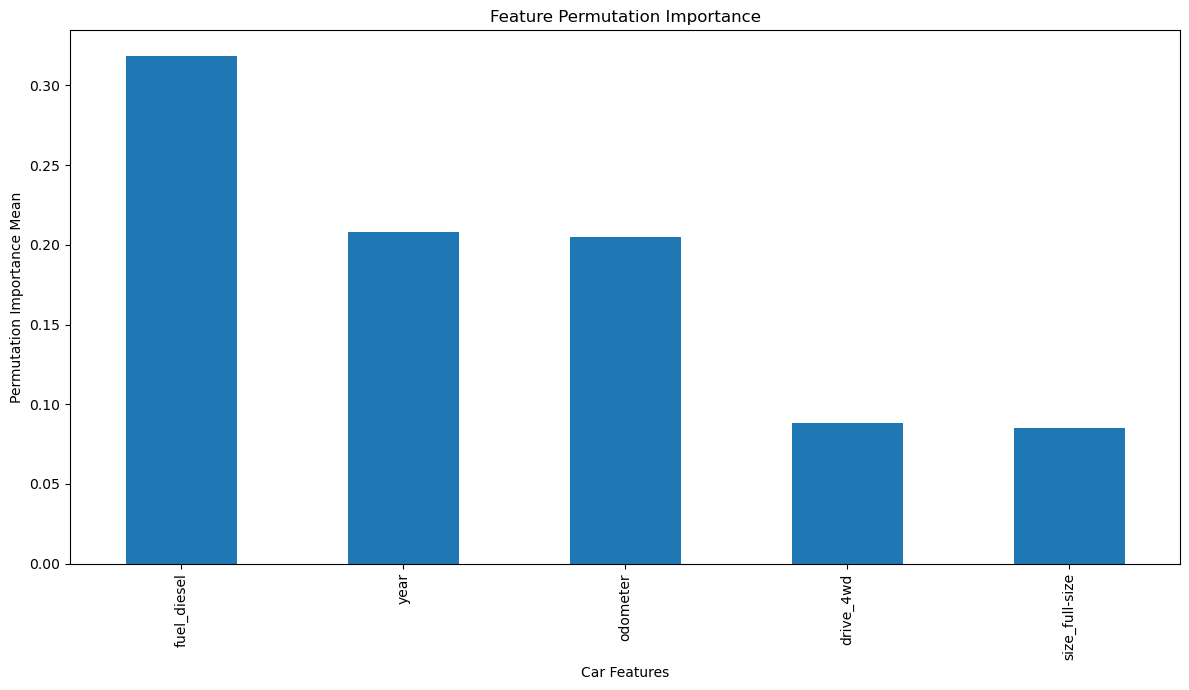

In [367]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df7.plot.bar(x=X7_test.columns, y=r7.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Car Features")

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Data Quality and Preparation Observations

The overall data quality presented several challenges. Many records contained missing or unrealistic values, such as a price of $0 or an odometer reading of 0, which are not plausible for used cars. While standard techniques like mean or median imputation are often used to address such issues, they were not suitable in this case due to the diverse range of vehicle features—such as fuel type, condition, size, and color—which would require a more nuanced, context-aware approach to imputation.

Given these limitations, we opted to remove records with clearly invalid values to preserve the integrity of the dataset. Additionally, we removed columns such as ID, VIN, state, manufacturer, and model, as they either acted as identifiers or did not provide meaningful predictive value for car pricing in the context of this analysis.

### Regression Model Observations

The goal of this project was to identify key features that influence used car prices, helping dealerships make more informed decisions about inventory and pricing strategies. After cleaning and preparing the data, we built and tested several regression models using different combinations of features.

Overall, most models struggled with low accuracy, largely due to the presence of missing or unrealistic values in the dataset. However, two models—Model6 and Model7—stood out by producing the most consistent and realistic predictions. These models focused on features such as odometer reading, vehicle year, fuel type (diesel), drivetrain (4WD), and vehicle size (full-size).

Despite modest accuracy scores, the insights gained provide valuable guidance on which vehicle characteristics tend to drive price. We recommend using these models as a foundation for further refinement and encouraging the dealership to collect more complete and consistent data moving forward.


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Introduction

This machine learning application was developed using a dataset of over 400,000 used car listings spanning multiple decades. The goal is to analyze the key factors that influence used car prices, helping your organization and sales team better understand what consumers value most.

By identifying these trends, you’ll be equipped to fine-tune your inventory strategy—stocking vehicles that are more aligned with consumer preferences—to ultimately drive higher sales and revenue.

Our approach followed a standard machine learning workflow: data collection, cleaning, preparation, feature selection, model training, and evaluation. To maintain and improve the model's performance over time, we recommend continuously integrating new sales data. This will allow for more accurate predictions and deeper insights into evolving market demand.

### Findings

# Data Processing
The first thing that was apparent from the provided data was that it was not clean, it had missing values and some of the values were not realistic for used cars, for example, odometer with zero and single digit values; price with zero and single digits values.

A Summary of the Data Preparation is as follows:

- Remove records with Zero Prices and Odometer values
- Remove records where some of the factors are not populated
- Drop a number of factors (i.e., VIN, id, region etc.) that are not significant in user car price determination
- Review and remove the other factors (i.e., state, paint color, manufacturer, transmission etc.) and check if they have an impact on car - price based on the provided data
- Filtering the data based on year on manufacture = 1990 as the number of used cars before 1990 were very low

# Data Application
With this data preparation, we used the following factors in building the Machine Learning application

- Price
- Year
- Condition
- Fuel Type
- Odometer
- Drive Train and
- Size
- In building and testing the application we observed that using car records with year greater than 1990 provided the best accuracy for the provided dataset.

This data provided an application with an accuracy of 47%+ when predicting used car prices using factors like odometer, year, fuel type, drive train and size.

When we analyzed the factors contributing to the used car price in the application, we observed the following order of importance:

1. Diesel Fuel
2. Year
3. Odometer
4. Four Wheel Drive and
5. Full Size
   
Based on these findings for this dataset, it looks like Consumers are more interested in Diesel fuel cars, followed by Year and Odometer (which are sometimes related). For example, a newer car should have lower mileage, there are exceptions, for example, Rental Cars. Four Wheel Drive (also known as All Wheel Drive) and Full Size cars were the fourth/fifth feature of importance.

### Conclusion

The dataset presented several challenges, including missing, null, zero, and unrealistic values. To improve model accuracy, further filtering can be applied—for example, limiting the dataset to used cars from the year 2000 onward. This would allow the model to focus on newer vehicles, which often contain more relevant and impactful features such as engine type, drivetrain, vehicle size, and condition—factors that tend to have a stronger influence on price.

Incorporating newer and more comprehensive data will also be critical to improving prediction accuracy. Modern features such as advanced driver-assistance systems (ADAS), infotainment systems, rear-view cameras, remote start, and real-time fuel efficiency can significantly affect consumer valuation of used vehicles and should be included in future datasets.

As a next step, while the current top-performing models (e.g., Model7) can be deployed for initial use, we strongly recommend collecting higher-quality and more recent data—specifically from vehicles no older than 10–15 years. With this approach, it is reasonable to expect a model accuracy of 75% or higher, offering greater confidence in pricing insights and inventory decisions.